<a href="https://colab.research.google.com/github/jhermosillo/keyword_extraction/blob/main/API_TextRank_GFractal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulos necesarios

In [1]:
# !pip install deplacy
# !pip install spacy

In [2]:
# !python3 -m spacy download en_core_web_sm
# !python3 -m spacy download es_core_news_sm

In [3]:
import pkg_resources,imp
imp.reload(pkg_resources)

/tmp/ipykernel_4312/801818587.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import pkg_resources,imp


<module 'pkg_resources' from '/usr/lib/python3/dist-packages/pkg_resources/__init__.py'>

### Librerías necesarias para los algoritmos

In [154]:
from math import *
from math import sqrt
import string
import enchant
import operator
import random
import pandas as pd
#librerias necesarias para text rank
from collections import OrderedDict
import numpy as np
import spacy

#Listado de STOPWORDS dependiendo del lenguaje
from spacy.lang.en.stop_words import STOP_WORDS
#from spacy.lang.es.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')
#nlp = spacy.load('es_core_news_sm')

In [155]:
!python3 -m pip install statsmodels # Para importar scoring

In [156]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import InputLayer,Dense,Dropout
# from tensorflow.keras.layers import BatchNormalization
from keras.layers import BatchNormalization
from keras.regularizers import l1,l1_l2,l2
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import RMSprop
# from keras.optimizers import RMSprop
from keras.layers.advanced_activations import LeakyReLU

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical #TensorFlow V 2.9
# from keras.utils import to_categorical

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

from scoring import *

# Algoritmo TextRank

In [7]:
class TextRank4Keyword():
    """Extract keywords from text"""

    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 100 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        keysw={}
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            keysw[key] =value
            if i > number:
                break
        return keysw
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight
        

# Algoritmo Grado de Fractalidad

In [8]:
#solamente se calcula el grado de fractalidad de las palabras que tengan mas de uno de frecuencia
def fractalidad(palabras,vocabulario,frec,dist):
    N=len(palabras)                                     #El número de tokens de todo el texto
    gf={}
    cajas_index=set()
    voc=[]                                             #la variable voc contendra cada sintagma con frecuencia mayor que 1, por que las otras palabras tendrán 0 de grado de fractaldiad
    for p in vocabulario:                              #Esto se puede hacer fuera del algoritmo, pero se incluye para evitar ese calculo innecesario 
        if(p not in voc):
            if(frec[p]>1):
                if(p not in STOP_WORDS):
                    if(len(p)>1):
                        voc.append(p)
    # print("Text size: ",N)
    # print("Vocabulary: ",len(voc))
    for p in voc:                                  
        rcajas=dist[p]
        M=frec[p]                                  
        dfw=0.0
        nsh=0.0
        for s in range(1,N+1):  
            noc=0                                       
            for e in rcajas:                       
                cajas_index.add(ceil(int(e)/s))    
            noc=len(cajas_index)                    
            cajas_index.clear()    
            ns=N/s
            if(M<=ns):
                nsh=M
            else:
                nsh=M/(1+(M-1)/(N-1)*(s-1)) 
            dfw=dfw+fabs(log(nsh/noc))
        gf[p]=dfw
    return gf    #regresamos un diccionario

In [9]:
def distribucion(palabras,vocabulario):
    N=len(palabras)
    ncajas=[]
    cajas={}
    frecuencias={}
    for p in vocabulario:
        ncajas.clear()
        i=0
        M=palabras.count(p)
        while(i<N):
            if(p == palabras[i]):
                ncajas.append(i+1)
            i=i+1
        frecuencias[p]=M
        cajas[p]=ncajas[:]
    return frecuencias,cajas

# Lectura de archivo de entrada

In [10]:
#Lectura de archivo para generación de vocabulario
def cargar_datos(filename):
    f=open(filename, "r") #tenemos que crear un directorio llamado InputData
    texto=f.read()
    #Pasar a minusculas
    texto=texto.lower()
    #Eliminar puntuación
    texto=texto.translate(str.maketrans('', '', string.punctuation))
    texto=texto.translate(str.maketrans('', '', '¿¡—“”0123456789’'))
    palabras=texto.split()
    textop=""
    #rearmamos el texto debido a ue existen carácteres especiales
    for w in palabras:
        textop=textop+w+' '
    return textop

DEFINICIÓN DEL NOMBRE DEL ARCHIVO A PROCESAR

Lectura de documentos

In [11]:
def lee_documento(filename='NULL',texto=''):
    if filename != 'NULL':
        texto=cargar_datos(filename)
    #obtenemos el vocabulario
    tokens=texto.split()
    vocabulario=[]
    for t in tokens:
        if(t not in vocabulario):
            vocabulario.append(t)
    #variables de procesamiento
    dist={}
    frec={}
    frec,dist=distribucion(tokens,vocabulario)
    return frec,dist,tokens,vocabulario,texto

# Ejecución de algoritmos y generación de archivos de salida

In [12]:
# lectura de documento de prueba
frec,dist,tokens,vocabulario,texto = lee_documento('data.txt')

## Grado de Fractalidad

In [13]:
#ejecución de algoritmo Grado de Fractalidad
def grado_de_fractalidad(tokens,vocabulario,frec,dist,regresa_kw=False,regresa_df=True,top_n=np.inf,escribe_arch=False):
    frac_x=fractalidad(tokens,vocabulario,frec,dist) 
    sorted_x = sorted(frac_x.items(), key=operator.itemgetter(1), reverse=True)
    # print('Time GF: '+str(elapsed_time))

    #Imprimir y guardar resultados de GF
    if regresa_df:
        if top_n != np.inf:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x[:top_n]]
        else:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x]
        #Ordenar resultados por medida combinada
        df.sort(key=lambda x: x[3],reverse=True)
        if regresa_kw==False:
            df = [dato[0] for dato in df]
            by_MC=pd.DataFrame(df, columns=['word'])
        else:   
            by_MC=pd.DataFrame(df, columns=['word','frecuency','Degree_of_fractality','Combined_measure'])
        if escribe_arch:
            by_MC.to_csv('GF.csv')
    else:
        if top_n != np.inf:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x[:top_n]]
        else:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x]
        #Ordenar resultados por medida combinada
        df.sort(key=lambda x: x[3],reverse=True)
        if regresa_kw==False:
            by_MC = [dato[0] for dato in df]
        else:
            by_MC = df
        if escribe_arch:
            print('\nNo se tiene implementada la escritura de archivo cuando regresa_df==False\n')
    return by_MC

def use_gf(texto,regresa_kw=False,regresa_df=False,top_n=np.inf,escribe_arch=False):
    tokens=texto.split()
    vocabulario=[]
    for t in tokens:
        if(t not in vocabulario):
            vocabulario.append(t)
    #variables de procesamiento
    dist={}
    frec={}
    frec,dist=distribucion(tokens,vocabulario)
    df = grado_de_fractalidad(tokens,vocabulario,frec,dist,regresa_kw,regresa_df,top_n,escribe_arch)
    return df

df1 = use_gf(texto,regresa_kw=True,regresa_df=True,top_n=10)
df1

,word,frecuency,Degree_of_fractality,Combined_measure
0,latin,4,167.127394,100.620717
1,content,3,205.903714,98.241038
2,humour,3,163.880039,78.190650
3,injected,3,163.200270,77.866318
4,dummy,2,191.726724,57.715495
5,type,2,191.726724,57.715495
6,line,2,179.412131,54.008433
7,internet,2,175.612973,52.864773
8,reproduced,2,169.604962,51.056181
9,typesetting,2,166.080279,49.995146


## TextRank

In [14]:
#ejecución de algoritmo de TextRank
# start_time = time()
def use_TextRank(texto,regresa_kw=False,regresa_df=False,top_n=np.inf,escribe_arch=False):
    tr4w = TextRank4Keyword()
    tr4w.analyze(texto, candidate_pos = ['NOUN','PROPN'], window_size=4, lower=False)
    kwTR=tr4w.get_keywords(100)

    #Guardar resultados de TextRank
    if regresa_df:
        if top_n!=np.inf:
            if regresa_kw==True:
                salida = [[key, kwTR[key]] for key in kwTR.keys()][:top_n]
                dftr=pd.DataFrame(salida, columns=['word', 'Index'])
            else:
                salida = list(kwTR.keys())[:top_n]
                dftr=pd.DataFrame(salida, columns=['word'])
        else:
            if regresa_kw==True:
                salida = [[key, kwTR[key]] for key in kwTR.keys()]
                dftr=pd.DataFrame(salida, columns=['word', 'Index'])
            else:
                salida = list(kwTR.keys())
                dftr=pd.DataFrame(salida, columns=['word'])
    else:
        if top_n!=np.inf:
            if regresa_kw==True:
                dftr = [[key, kwTR[key]] for key in kwTR.keys()][:top_n]
            else:
                dftr = list(kwTR.keys())[:top_n]
        else:
            if regresa_kw==True:
                dftr = [[key, kwTR[key]] for key in kwTR.keys()]
            else:
                dftr = list(kwTR.keys())
        # elapsed_time = time() - start_time
        # print('Time TextRank: '+str(elapsed_time))
        if escribe_arch:
            dftr.to_csv('TextRank.csv')
    return dftr

dftr = use_TextRank(texto,top_n=10)
dftr

['ipsum',
 'lorem',
 'words',
 'versions',
 's',
 'text',
 'bc',
 'book',
 'humour',
 'years']

# 20 Newsgroups

In [15]:
def preprocess_text(r,remove_STW=True,lemmatize=False):
    def check_STW(palabras):
        texto = [w for w in palabras \
                 if not w in STOP_WORDS and len(w)>2]
        return texto
    def remove_basura(palabras):
        #basura = pd.read_csv('basura.txt',sep='\n',names=['words']) # El separador \n marca ValueError
        # basura = pd.read_csv('basura.txt',names=['words'])
        # basura = basura.words.tolist()
        d = enchant.Dict("en_US")
        texto = [w for w in palabras if d.check(w)]
        return texto        
    r1=r.cadena.str.translate(\
          str.maketrans('','',string.digits))\
          .str.translate(\
          str.maketrans('','',string.punctuation))\
          .str.replace('«','', regex=True)\
          .str.replace('»','', regex=True).str.replace('(','', regex=True)\
          .str.replace('\n',' ', regex=True)\
          .str.replace('`','', regex=True)\
          .str.replace('*','', regex=True)\
          .str.replace('"','', regex=True)\
          .str.replace(')','', regex=True).str.strip().str.lower()
    if remove_STW:
        r1=r1.to_frame().applymap(lambda x : x.split()).applymap(check_STW).applymap(lambda x: ' '.join(x))
        r1=r1.applymap(lambda x : x.split()).applymap(remove_basura).applymap(lambda x: ' '.join(x))
    if lemmatize:
        if isinstance(r1, pd.DataFrame):
            r1=r1.applymap(lambda x : nlp(x)).applymap(lambda x: ' '.join([token.lemma_ for token in x]))        
        else:
            r1=r1.to_frame().applymap(lambda x : nlp(x)).applymap(lambda x: ' '.join([token.lemma_ for token in x]))        
    r.cadena = r1
    r=r.rename(columns={'cadena':'docs'})
    return r

### Aqui empieza lo que tengo que ver que funcione

In [16]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))

from pprint import pprint
# pprint(list(newsgroups_train.target_names))

cats=list(newsgroups_train.target_names)
n = len(cats)//2
cats1=cats[:n]
cats2=cats[n:]
# print(cats)
print(cats1)
print(cats2)
categories = [cats1,cats2]

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball']
['rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [17]:
def process_20NG(categories,n=20,th=5,remove_STW=True,lemmatize=False):
    data=[]
    for i,cats in enumerate(categories):
        newsgroups_train = fetch_20newsgroups(subset='train', 
                                        remove=('headers', 'footers', 'quotes'),
                                        categories=cats)
        df = pd.DataFrame(newsgroups_train.data, columns=['cadena'])
        df['target'] = pd.Series(newsgroups_train.target+len(cats)*i)
        df = preprocess_text(df,remove_STW=remove_STW,lemmatize=lemmatize)
        df['TR'] = df.docs.apply(lambda x : use_TextRank(x,top_n=n))
        df['GF'] = df.docs.apply(lambda x : use_gf(x,top_n=n))
        df=df.drop(df[df.TR.apply(lambda x: len(x)<th)].index).reset_index(drop=True)
        df=df.drop(df[df.GF.apply(lambda x: len(x)<th)].index).reset_index(drop=True)
        data.append(df)
    lista=range(len(categories))
    newsgroups_data = data[0]
    if len(lista)>1:
        for j in lista[1:]:
            newsgroups_data = newsgroups_data.append(data[j],ignore_index=True)
    newsgroups_data = newsgroups_data.sample(frac=1).reset_index(drop=True)
    # newsgroups_data.to_csv('newsgroups_train_data.csv')
    return newsgroups_data

In [18]:
newsgroups_train_data = process_20NG(categories,n=100,remove_STW=True,lemmatize=True)
newsgroups_train_data

/tmp/ipykernel_4312/3745100282.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  newsgroups_data = newsgroups_data.append(data[j],ignore_index=True)


,docs,target,TR,GF
0,centris get mac processor builtin math coproce...,4,"[apple, nonfpu, centris, processor, support, c...","[system, fpu, apple, nonfpu, centris, memo, pr..."
1,course you re plan pull rushdie declare one le...,0,"[statement, rushdie, islamic, islam, country, ...","[clear, islamic, statement, country, islam, pl..."
2,note radiosity package resource list subject f...,1,"[resource, athens, greece, list, conference, c...","[nick, list, greece, athens, resource]"
3,correction addition hellman note courtesy doro...,11,"[fbi, key, chip, bit, unit, clipper, law, den,...","[fbi, key, bit, number, link, clipper, algorit..."
4,note time times year funny thing happen bike e...,8,"[way, air, bike, mile, screw, carb, time, lane...","[screw, way, lane, mood, run, air, inside, mil..."
...,...,...,...,...
4912,thing historical perspective turk move area in...,17,"[greek, nation, thing, turkey, area, perspecti...","[greek, nation, perspective, work, turkey, rea..."
4913,handler key depository irrelevant order applic...,11,"[agency, number, escrow, nsa, order, law, depo...","[key, need, agency, nsa, order, serial, number..."
4914,hand kind scary final verdict party litigation...,18,"[trial, litigation, witness, general, motor, p...","[trial, general, new, witness, find, litigatio..."
4915,easy question window guru appreciate help need...,2,"[file, help, application, window, hlp, generat...","[file, application, help, window, rtf, hcexe, ..."


In [19]:
print(np.unique(newsgroups_train_data.target))
print(newsgroups_train_data.GF.values[:5])
print(newsgroups_train_data.TR.values[:5])
df = newsgroups_train_data.copy()
df

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[list(['system', 'fpu', 'apple', 'nonfpu', 'centris', 'memo', 'processor', 'configuration', 'support', 'upgrade'])
 list(['clear', 'islamic', 'statement', 'country', 'islam', 'plan', 'rushdie', 'leave'])
 list(['nick', 'list', 'greece', 'athens', 'resource'])
 list(['fbi', 'key', 'bit', 'number', 'link', 'clipper', 'algorithm', 'encrypt', 'pass', 'authority', 'system', 'form', 'agency', 'unit', 'message', 'serial', 'den', 'generate', 'chip', 'law', 'des', 'block', 'change', 'produce', 'second', 'let', 'note', 'single', 'posting', 'enforcement', 'person', 'think', 'decode', 'approval', 'box', 'compute', 'flow', 'session', 'order', 'suggestion', 'court', 'know', 'seed', 'wiretap', 'agent', 'information', 'tell', 'folk', 'add', 'request', 'dorothy', 'escrow', 'ask', 'general', 'attorney', 'include', 'addition', 'decrypt', 'operate', 'use', 'establish', 'record', 'martys', 'user', 'nsa', 'like'])
 list(['screw', 'way', 'lane', '

,docs,target,TR,GF
0,centris get mac processor builtin math coproce...,4,"[apple, nonfpu, centris, processor, support, c...","[system, fpu, apple, nonfpu, centris, memo, pr..."
1,course you re plan pull rushdie declare one le...,0,"[statement, rushdie, islamic, islam, country, ...","[clear, islamic, statement, country, islam, pl..."
2,note radiosity package resource list subject f...,1,"[resource, athens, greece, list, conference, c...","[nick, list, greece, athens, resource]"
3,correction addition hellman note courtesy doro...,11,"[fbi, key, chip, bit, unit, clipper, law, den,...","[fbi, key, bit, number, link, clipper, algorit..."
4,note time times year funny thing happen bike e...,8,"[way, air, bike, mile, screw, carb, time, lane...","[screw, way, lane, mood, run, air, inside, mil..."
...,...,...,...,...
4912,thing historical perspective turk move area in...,17,"[greek, nation, thing, turkey, area, perspecti...","[greek, nation, perspective, work, turkey, rea..."
4913,handler key depository irrelevant order applic...,11,"[agency, number, escrow, nsa, order, law, depo...","[key, need, agency, nsa, order, serial, number..."
4914,hand kind scary final verdict party litigation...,18,"[trial, litigation, witness, general, motor, p...","[trial, general, new, witness, find, litigatio..."
4915,easy question window guru appreciate help need...,2,"[file, help, application, window, hlp, generat...","[file, application, help, window, rtf, hcexe, ..."


In [20]:
newsgroups_train_data.to_pickle('newsgroups_train_data_sinSW_lemma_Top100.pickle')

## Lectura de archivo procesado

In [21]:
df = pd.read_pickle('newsgroups_train_data_sinSW_lemma_Top100.pickle')
df

,docs,target,TR,GF
0,centris get mac processor builtin math coproce...,4,"[apple, nonfpu, centris, processor, support, c...","[system, fpu, apple, nonfpu, centris, memo, pr..."
1,course you re plan pull rushdie declare one le...,0,"[statement, rushdie, islamic, islam, country, ...","[clear, islamic, statement, country, islam, pl..."
2,note radiosity package resource list subject f...,1,"[resource, athens, greece, list, conference, c...","[nick, list, greece, athens, resource]"
3,correction addition hellman note courtesy doro...,11,"[fbi, key, chip, bit, unit, clipper, law, den,...","[fbi, key, bit, number, link, clipper, algorit..."
4,note time times year funny thing happen bike e...,8,"[way, air, bike, mile, screw, carb, time, lane...","[screw, way, lane, mood, run, air, inside, mil..."
...,...,...,...,...
4912,thing historical perspective turk move area in...,17,"[greek, nation, thing, turkey, area, perspecti...","[greek, nation, perspective, work, turkey, rea..."
4913,handler key depository irrelevant order applic...,11,"[agency, number, escrow, nsa, order, law, depo...","[key, need, agency, nsa, order, serial, number..."
4914,hand kind scary final verdict party litigation...,18,"[trial, litigation, witness, general, motor, p...","[trial, general, new, witness, find, litigatio..."
4915,easy question window guru appreciate help need...,2,"[file, help, application, window, hlp, generat...","[file, application, help, window, rtf, hcexe, ..."


In [22]:
df = df.drop(df[df.TR.apply(lambda x: len(x)<5)].index).reset_index(drop=True)
df = df.drop(df[df.GF.apply(lambda x: len(x)<5)].index).reset_index(drop=True)
df

,docs,target,TR,GF
0,centris get mac processor builtin math coproce...,4,"[apple, nonfpu, centris, processor, support, c...","[system, fpu, apple, nonfpu, centris, memo, pr..."
1,course you re plan pull rushdie declare one le...,0,"[statement, rushdie, islamic, islam, country, ...","[clear, islamic, statement, country, islam, pl..."
2,note radiosity package resource list subject f...,1,"[resource, athens, greece, list, conference, c...","[nick, list, greece, athens, resource]"
3,correction addition hellman note courtesy doro...,11,"[fbi, key, chip, bit, unit, clipper, law, den,...","[fbi, key, bit, number, link, clipper, algorit..."
4,note time times year funny thing happen bike e...,8,"[way, air, bike, mile, screw, carb, time, lane...","[screw, way, lane, mood, run, air, inside, mil..."
...,...,...,...,...
4912,thing historical perspective turk move area in...,17,"[greek, nation, thing, turkey, area, perspecti...","[greek, nation, perspective, work, turkey, rea..."
4913,handler key depository irrelevant order applic...,11,"[agency, number, escrow, nsa, order, law, depo...","[key, need, agency, nsa, order, serial, number..."
4914,hand kind scary final verdict party litigation...,18,"[trial, litigation, witness, general, motor, p...","[trial, general, new, witness, find, litigatio..."
4915,easy question window guru appreciate help need...,2,"[file, help, application, window, hlp, generat...","[file, application, help, window, rtf, hcexe, ..."


# Distribución del vocabulario (no correr)

In [23]:
from nltk.tokenize import word_tokenize

textos = df['TR'].values.tolist()
t = ' '.join(textos[0])
for l in textos[1:]:
    t += ' '.join(l)
vocTR = set(word_tokenize(t))
print(len(vocTR),'palabras únicas (tipos)')

38540 palabras únicas (tipos)


In [24]:
textos = df['GF'].values.tolist()
t = ' '.join(textos[0])
for l in textos[1:]:
    t += ' '.join(l)
vocGF = set(word_tokenize(t))
print(len(vocGF),'palabras únicas (tipos)')

18884 palabras únicas (tipos)


In [25]:
basura = []
for w in vocTR:
    if len(w) > 12:
        basura.append(w)
TRvoc = []
for w in vocTR:
    if w not in basura:
        TRvoc.append(w)
print(len(TRvoc))
np.savetxt('basura_TR.txt',basura,fmt = '%s',delimiter=',')

33455


In [26]:
basura = []
for w in vocGF:
    if len(w) > 12:
        basura.append(w)
GFvoc = []
for w in vocGF:
    if w not in basura:
        GFvoc.append(w)
print(len(GFvoc))
np.savetxt('basura_GF.txt',basura,fmt = '%s',delimiter=',')

16822


In [27]:
#basura_TR = pd.read_csv('basura_TR.txt',sep='\n',names=['words']) # Value error with sep='\n'
basura_TR = pd.read_csv('basura_TR.txt',names=['words'])
#basura_GF = pd.read_csv('basura_GF.txt',sep='\n',names=['words']) # Value error with sep='\n'
basura_GF = pd.read_csv('basura_GF.txt',names=['words'])
basura = pd.concat([basura_TR,basura_GF])
basura = basura.words.tolist()

np.savetxt('basura.txt',basura,fmt = '%s',delimiter=',')

In [28]:
vocINTER = list(set(TRvoc).intersection(set(GFvoc)))
print(len(vocINTER))

11355


# Word2vec

In [29]:
# import modules & set up logging
from gensim.models import Word2Vec as w2v
import gensim.downloader as api

def vocdf(df,vec_size=100):
    # obtain vocabulary word types 
    types=df['docs'].str.split(' ', expand=True).stack().unique()
    # Data Frame of vocabulary and word embeddings
    typesDF=pd.Series(types).to_frame()
    typesDF.rename(index=int,columns={0:'Palabra'},inplace=True)

    #Add Emebddings placeholders
    #Se necesita convertir el DF a diccionario
    #luego se agregan vectores de dimension N,
    #como registros nuevos del diccionario
    #para reconvertirlo en un DF de vuelta
    dico=typesDF.to_dict('records',into=OrderedDict)
    #Add real-valued embedding vectors
    for reg in dico:
        reg['W2V']=np.zeros(vec_size)
    typesDF=pd.DataFrame.from_dict(dico)
    typesDF.set_index('Palabra',inplace=True)
    return typesDF 

def compute_embeddings(df,typesdf,vec_dim=100):
    
    docs = df["docs"].values.tolist()
    docs = [s.split() for s in docs]
    model = w2v(docs, min_count=1, vector_size=vec_dim)
    words = typesdf.index.values.tolist()
    for w in words:
        typesdf.at[w,'W2V'] = model.wv[w]
    return model

typesDF = vocdf(df)
print(typesDF.iloc[0].W2V.shape)

modelo = compute_embeddings(df,typesDF)
print(typesDF.loc['sound'])
typesDF.to_pickle('typesDF_WE.pickle')
typesDF.head()
# model.wv['sound']
# model.wv.most_similar('good', topn=10) 

(100,)
W2V    [0.69577163, 1.0818397, -1.0889486, 0.48896378...
Name: sound, dtype: object


,W2V
Palabra,
centris,"[0.09639737, 0.18288672, -0.25443465, -0.09307..."
get,"[1.0621133, 1.5670474, -0.04544715, -0.3226263..."
mac,"[0.26984242, 0.7057565, -1.1645731, -0.0327344..."
processor,"[0.018654697, 0.3177327, -0.46774548, 0.087116..."
builtin,"[0.21916953, 0.3601302, -0.7692143, -0.0686266..."


In [30]:
vectores = {}

for index, strings in typesDF.iterrows():
    vectores[index] = strings[0]


In [31]:
vectores['countersteer']

array([ 1.0539024e-02,  2.7749063e-02, -4.7620698e-03,  8.8223815e-03,
       -2.0289788e-02, -1.1124894e-02,  4.5932963e-02,  2.5507014e-02,
        3.7027288e-03, -2.0095138e-03,  2.6081258e-02, -4.7072645e-02,
        1.1314730e-03,  9.7194640e-03, -2.5587896e-02,  1.2845773e-02,
       -2.8528322e-03,  2.9950382e-02, -1.5183073e-02, -6.9280309e-03,
        1.5170917e-05, -3.2422710e-02,  1.3079323e-02,  1.7472269e-02,
       -4.6788976e-03,  1.6878374e-02,  2.5644086e-03, -3.0362972e-03,
       -1.1445336e-02, -1.3186249e-02, -7.0358468e-03,  4.3358253e-03,
        3.8596816e-02, -2.0505391e-02, -1.2911040e-02,  2.7286010e-02,
        3.3219006e-02,  3.0514786e-02, -1.9838830e-02,  1.8994184e-02,
       -1.2685299e-02,  2.6879916e-02, -6.1133015e-03, -1.6211284e-02,
        1.3549729e-02, -2.5077194e-02,  6.0968925e-03,  6.3421014e-03,
        1.9833896e-02,  2.7343856e-02, -6.0051247e-03,  2.5105117e-02,
       -2.7726050e-02, -7.2867484e-03,  2.0680254e-02, -2.8752275e-02,
      

In [32]:
# print(new_df.TR.values)


In [165]:
typesDF = pd.read_pickle('typesDF_WE.pickle')
typesDF.head()

,W2V
Palabra,
centris,"[0.09639737, 0.18288672, -0.25443465, -0.09307..."
get,"[1.0621133, 1.5670474, -0.04544715, -0.3226263..."
mac,"[0.26984242, 0.7057565, -1.1645731, -0.0327344..."
processor,"[0.018654697, 0.3177327, -0.46774548, 0.087116..."
builtin,"[0.21916953, 0.3601302, -0.7692143, -0.0686266..."


# Separacion de dataframe por clase

## Ahora para todas las clases

In [34]:
from collections import Counter

In [264]:
def top100_clase(data_frame, clase, algoritmo):
    '''Función que genera el vocabulario de las Top 100 palabras de una clase y de un algoritmo específico, dado una DataFrame.

    data_frame: La DataFrame de la cual provienen los documentos.
    clase: La clase de documento del cual queremos obtener las palabras.
    algoritmo: El algoritmo del cual queremos obtener las palabras. 0 para TextRank, 1 para Grado de Fractalidad'''

    df_clase = data_frame.drop(data_frame[data_frame.target != clase].index) # Obtenemos los documentos de la clase que requerimos
    if algoritmo == 0: # Usando el algoritmo TextRank
        text = df_clase.TR.values
    if algoritmo == 1: # Usando el algoritmo Grado de Fractalidad
        text = df_clase.GF.values

    palabras = []
    for d in text: # Obtenemos todas las palabras obtenidas por el algoritmo
        for palabra in d:
            palabras.append(palabra)
    palabras = Counter(palabras) # Contamos la frecuencia de cada palabra

    top = pd.DataFrame(palabras.items(), columns=['docs','Frecuencia'])
    top = top.sort_values(by=['Frecuencia'],ascending=False) # Ordenamos por frecuencia de orden descendente
    top = top.reset_index(drop=True) 

    top_types = vocdf(top)
    compute_embeddings(top, top_types)

    # top = # Realizamos las vectorizaciones del top de las palabras de una clase.

    tem = top.copy() # Creamos un DataFrame temporal
    top['Vector'] = "" # Creamos una nueva columna, por el momento vacía

    for index, strings in tem.iterrows(): # Para cada indice y string, iteramos en las filas de tem (DataFrame temporal)
        # top.at[index,'Vector'] = vectores[strings[0]] # Añadimos el vector correspondiente a la palabra en su indice dado
        top.at[index,'Vector'] = top_types.iloc[index]['W2V']
    top.rename(columns = {'docs':'Palabra'}, inplace = True)
    return top # Regresamos los elementos ordenados por top frecuencia, para luego poder reducir a 100, por ejemplo

In [265]:
df_vect = pd.read_pickle('newsgroups_train_data_sinSW_lemma_Top100.pickle')

df_vect = df_vect.drop(df[df.TR.apply(lambda x: len(x)<5)].index).reset_index(drop=True)
df_vect = df_vect.drop(df[df.GF.apply(lambda x: len(x)<5)].index).reset_index(drop=True)

In [266]:
df_vect

,docs,target,TR,GF
0,centris get mac processor builtin math coproce...,4,"[apple, nonfpu, centris, processor, support, c...","[system, fpu, apple, nonfpu, centris, memo, pr..."
1,course you re plan pull rushdie declare one le...,0,"[statement, rushdie, islamic, islam, country, ...","[clear, islamic, statement, country, islam, pl..."
2,note radiosity package resource list subject f...,1,"[resource, athens, greece, list, conference, c...","[nick, list, greece, athens, resource]"
3,correction addition hellman note courtesy doro...,11,"[fbi, key, chip, bit, unit, clipper, law, den,...","[fbi, key, bit, number, link, clipper, algorit..."
4,note time times year funny thing happen bike e...,8,"[way, air, bike, mile, screw, carb, time, lane...","[screw, way, lane, mood, run, air, inside, mil..."
...,...,...,...,...
4912,thing historical perspective turk move area in...,17,"[greek, nation, thing, turkey, area, perspecti...","[greek, nation, perspective, work, turkey, rea..."
4913,handler key depository irrelevant order applic...,11,"[agency, number, escrow, nsa, order, law, depo...","[key, need, agency, nsa, order, serial, number..."
4914,hand kind scary final verdict party litigation...,18,"[trial, litigation, witness, general, motor, p...","[trial, general, new, witness, find, litigatio..."
4915,easy question window guru appreciate help need...,2,"[file, help, application, window, hlp, generat...","[file, application, help, window, rtf, hcexe, ..."


### Algunos tests de la funcion top100_clase

In [268]:
voc_c1_tr = top100_clase(df, 1, 0) # Generamos el top 100 de la clase 2 con el algoritmo Text Rank
voc_c1_tr

,Palabra,Frecuencia,Vector
0,program,57,"[0.008761696, -0.00595932, 0.005883015, -0.006..."
1,file,54,"[0.0009464085, 0.00092888233, 0.003723569, 0.0..."
2,image,47,"[0.004485371, 0.004608543, 0.0013751459, 0.001..."
3,computer,42,"[-0.0015418363, -0.0023518968, 0.0028680013, -..."
4,use,40,"[0.0099982405, 0.0046283915, 0.0028452242, -0...."
...,...,...,...
2930,smatter,1,"[-0.0061986973, -0.008898449, -0.0036371492, -..."
2931,paradigm,1,"[0.00864038, 0.009149633, -0.000114414695, -0...."
2932,sausalito,1,"[0.0032390999, -0.0012924457, 0.005948013, -0...."
2933,carlsbad,1,"[0.008254734, 0.008057727, -0.008295579, 0.007..."


In [249]:
voc_c1_tr = top100_clase(df, 2, 0) # Generamos el top 100 de la clase 3 con el algoritmo Text Rank
voc_c1_tr.head()


,docs,Frecuencia,Vector
0,window,104,"[-0.0006747639, -0.0036086857, -0.008615418, -..."
1,file,74,"[0.0041196872, 0.0014852858, 0.008652984, -0.0..."
2,problem,59,"[-0.0038482905, 0.0025296796, -0.0027482903, -..."
3,use,51,"[0.00078617455, 0.008613357, -0.008801285, 0.0..."
4,windows,49,"[-0.009017105, 0.006071875, 0.004715357, -0.00..."


In [190]:
# Como utilizar W2V para obtener los vectores de una palabra específica

tem = voc_c1_tr.copy() # Creamos un DataFrame temporal
voc_c1_tr['Vector'] = "" # Creamos una nueva columna, por el momento vacía

for index, strings in tem.iterrows(): # Para cada indice y string, iteramos en las filas de tem (DataFrame temporal)
    voc_c1_tr.at[index,'Vector'] = vectores[strings[0]] # Añadimos el vector correspondiente a la palabra en su indice dado


# voc_c1_tr.assign(Vector = lambda x: vectores[x])

In [191]:
voc_c1_tr # Revisamos el dataframe con su nueva columna de Vector, ya llena

,docs,Frecuencia,Vector
0,program,57,"[0.8394055, 0.8672715, -1.6075137, -0.7670616,..."
1,file,54,"[0.5463911, 0.3033426, -1.3462868, -0.5477546,..."
2,image,47,"[0.53292805, 0.1207558, -2.1019433, -0.1319566..."
3,computer,42,"[-0.19852728, 0.81022495, -1.1023575, -0.22643..."
4,use,40,"[-0.29939726, 1.5436862, -1.0348653, 0.0080260..."
...,...,...,...
95,paper,11,"[0.37785888, 0.6863816, -0.61859345, -0.419983..."
96,frame,11,"[0.29156655, 0.33400238, -0.6622926, -0.084092..."
97,people,11,"[0.22938745, 2.5159988, -0.22397158, 0.7384606..."
98,process,11,"[0.004912466, 1.0002241, -0.8767153, 0.2179839..."


In [250]:
top100_clase(df,12,1).head(20)

,docs,Frecuencia,Vector
0,use,30,"[0.0012067831, 0.0074788798, -0.007457795, 0.0..."
1,power,20,"[-0.007533412, -0.0019900263, 0.00474206, -0.0..."
2,work,20,"[0.0037813461, 0.008213975, -0.009543858, -0.0..."
3,good,19,"[-0.008922508, 8.125186e-05, -0.0062896037, 0...."
4,like,18,"[-0.0085396, -0.0027972662, 0.008547886, -0.00..."
5,current,17,"[-0.0012203169, -0.007179942, 0.0067165303, 0...."
6,know,17,"[-0.0013117683, 0.004911989, 0.00808614, -0.00..."
7,chip,16,"[-0.00016740084, 0.007129288, 0.009016354, 0.0..."
8,ve,16,"[0.007591903, 0.004428315, 0.0043647382, -0.00..."
9,high,15,"[-0.0043875338, 0.007568749, 0.009044929, -0.0..."


In [251]:
test = df_vect.sample(frac=0.2) # Separamos al Train y Test en un 80/20
df_vect = df_vect.drop(labels=test.index)

test

,docs,target,TR,GF
2420,nntppostinghost elm know sound stupid know con...,5,"[button, event, mouse, press, control, answer,...","[button, event, know, press, mouse, buttonpres..."
3873,look trunk time heck look dash funny thing att...,16,"[cop, round, gun, member, shoot, time, trunk, ...","[round, cop, look, shoot, know, trunk, suppose..."
3782,sorry do not tell exactly need need utility au...,2,"[file, utility, run, program, winini, update, ...","[need, run, program, file, utility]"
820,vlbus ide fast isa ide ide interface fundament...,3,"[isa, vlbus, hook, bus, ide, extension, interf...","[ide, isa, slow, vlbus, fast]"
472,ask question do not want people answer believe...,18,"[prostitution, people, drug, idea, legalizatio...","[question, ask, safe, prostitution, legalizati..."
...,...,...,...,...
4698,pair akg headphone sale electrostatic dyanmic ...,6,"[headphone, pair, end, cdn, sale, dyanmic, con...","[like, headphone, pair, end, electrostatic]"
30,pretty obvious illegal loud noise immediately ...,11,"[clinton, chip, problem, clipper, country, gov...","[need, chip, clipper, know, clinton, problem, ..."
3516,medical info namebody attach completely useles...,16,"[info, folk, deal, fail, policy, cash, secret,...","[info, public, secure, disclose, know, useless]"
2429,netter follow vacation package sale bahama vac...,6,"[vacation, hotel, accomodation, ticket, round,...","[vacation, night, accomodation, hotel, ticket,..."


In [252]:
df_vect = df_vect.reset_index(drop=True)
test = test.reset_index(drop=True)

In [253]:
test

,docs,target,TR,GF
0,nntppostinghost elm know sound stupid know con...,5,"[button, event, mouse, press, control, answer,...","[button, event, know, press, mouse, buttonpres..."
1,look trunk time heck look dash funny thing att...,16,"[cop, round, gun, member, shoot, time, trunk, ...","[round, cop, look, shoot, know, trunk, suppose..."
2,sorry do not tell exactly need need utility au...,2,"[file, utility, run, program, winini, update, ...","[need, run, program, file, utility]"
3,vlbus ide fast isa ide ide interface fundament...,3,"[isa, vlbus, hook, bus, ide, extension, interf...","[ide, isa, slow, vlbus, fast]"
4,ask question do not want people answer believe...,18,"[prostitution, people, drug, idea, legalizatio...","[question, ask, safe, prostitution, legalizati..."
...,...,...,...,...
978,pair akg headphone sale electrostatic dyanmic ...,6,"[headphone, pair, end, cdn, sale, dyanmic, con...","[like, headphone, pair, end, electrostatic]"
979,pretty obvious illegal loud noise immediately ...,11,"[clinton, chip, problem, clipper, country, gov...","[need, chip, clipper, know, clinton, problem, ..."
980,medical info namebody attach completely useles...,16,"[info, folk, deal, fail, policy, cash, secret,...","[info, public, secure, disclose, know, useless]"
981,netter follow vacation package sale bahama vac...,6,"[vacation, hotel, accomodation, ticket, round,...","[vacation, night, accomodation, hotel, ticket,..."


In [254]:
df_vect

,docs,target,TR,GF
0,centris get mac processor builtin math coproce...,4,"[apple, nonfpu, centris, processor, support, c...","[system, fpu, apple, nonfpu, centris, memo, pr..."
1,note radiosity package resource list subject f...,1,"[resource, athens, greece, list, conference, c...","[nick, list, greece, athens, resource]"
2,correction addition hellman note courtesy doro...,11,"[fbi, key, chip, bit, unit, clipper, law, den,...","[fbi, key, bit, number, link, clipper, algorit..."
3,good display active matrix panel bright overhe...,4,"[projector, panel, proxima, price, overhead, o...","[projector, bright, panel, price, overhead, go..."
4,need include vat previous level vat difference...,18,"[level, vat, government, difference, tax, end,...","[vat, tax, level, government, receive, differe..."
...,...,...,...,...
3929,think nhlpa good video game available course t...,10,"[game, team, shooter, period, minute, course, ...","[scorer, team, good, game, play]"
3930,thing historical perspective turk move area in...,17,"[greek, nation, thing, turkey, area, perspecti...","[greek, nation, perspective, work, turkey, rea..."
3931,handler key depository irrelevant order applic...,11,"[agency, number, escrow, nsa, order, law, depo...","[key, need, agency, nsa, order, serial, number..."
3932,hand kind scary final verdict party litigation...,18,"[trial, litigation, witness, general, motor, p...","[trial, general, new, witness, find, litigatio..."


In [270]:
voc_TR_clases = [] # Lista de Diccionarios de los vocabularios de todas las clases con TR (Contiene Vectorizaciones de palabra por clase)
voc_GF_clases = [] # Lista de Diccionarios de los vocabularios de todas las clases con GF (Contiene Vectorizaciones de palabra por clase)

for j in range(20):
    voc = top100_clase(df, j, 0)
    voc = voc.to_dict()
    voc_TR_clases.append(voc)
    voc = top100_clase(df, j, 1)
    voc = voc.to_dict()
    voc_GF_clases.append(voc)

### Ahora añadimos las vectorizaciones de las palabras para cada documento, según el algoritmo ocupado y su clase.

In [46]:
print(df_vect.iloc[0][3])

['system', 'fpu', 'apple', 'nonfpu', 'centris', 'memo', 'processor', 'configuration', 'support', 'upgrade']


In [47]:
len(df_vect.iloc[0][3])

10

In [258]:
df_vect.head(10)

,docs,target,TR,GF,VTR,VGF
0,centris get mac processor builtin math coproce...,4,"[apple, nonfpu, centris, processor, support, c...","[system, fpu, apple, nonfpu, centris, memo, pr...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,note radiosity package resource list subject f...,1,"[resource, athens, greece, list, conference, c...","[nick, list, greece, athens, resource]",,
2,correction addition hellman note courtesy doro...,11,"[fbi, key, chip, bit, unit, clipper, law, den,...","[fbi, key, bit, number, link, clipper, algorit...",,
3,good display active matrix panel bright overhe...,4,"[projector, panel, proxima, price, overhead, o...","[projector, bright, panel, price, overhead, go...",,
4,need include vat previous level vat difference...,18,"[level, vat, government, difference, tax, end,...","[vat, tax, level, government, receive, differe...",,
5,computer soundblaster card run microsoft windo...,2,"[midi, file, window, microsoft, driver, know, ...","[midi, file, driver, window, play, set, author...",,
6,snip snip box base arm risc processor custom g...,1,"[compactvideo, movie, chip, size, machine, arm...","[arm, snip, material, ramvram, graphic, chip, ...",,
7,parent seder notice labelling package english ...,15,"[question, christians, descent, writer, packag...","[know, french, descent, writer, jewish, questi...",,
8,hit land record telco access telco be not supp...,11,"[warrant, conversation, judge, exception, toda...","[record, telco, think, warrant, exception, con...",,
9,follow god blindly ask physically blind person...,15,"[god, experience, christians, truth, love, fai...","[believe, blind, hear, faith, know, god, follo...",,


In [259]:
#np.zeros((100,100), dtype=float)

In [273]:
''' Forma más rápida de obtener top 100 palabras vectorizadas, regresa valores mas pequeños de las palabras vectorizadas '''

df_vect['VTR'] = ""
df_vect['VGF'] = ""

for index, row in df_vect.iterrows():
    df_vect._set_value(index, 'VTR', np.zeros((100,100),dtype=float))
    df_vect._set_value(index, 'VGF', np.zeros((100,100),dtype=float))

    clase = row.target
    temp_list = []
    for j in range(100):
        if voc_TR_clases[clase]['Palabra'][j] in row.TR:
            temp_list.append(voc_TR_clases[clase]['Vector'][j])
        else:
            temp_list.append(np.zeros(100))
    df_vect._set_value(index, 'VTR', temp_list)
    temp_list = []
    for j in range(100):
        if voc_GF_clases[clase]['Palabra'][j] in row.GF:
            temp_list.append(voc_GF_clases[clase]['Vector'][j])
        else:
            temp_list.append(np.zeros(100))
    df_vect._set_value(index, 'VGF', temp_list)

In [274]:
df_vect

,docs,target,TR,GF,VTR,VGF
0,centris get mac processor builtin math coproce...,4,"[apple, nonfpu, centris, processor, support, c...","[system, fpu, apple, nonfpu, centris, memo, pr...","[[0.0034533334, 0.002015996, 0.003045324, 0.00...","[[0.0005604684, 0.0042308164, 0.004935186, -0...."
1,course you re plan pull rushdie declare one le...,0,"[statement, rushdie, islamic, islam, country, ...","[clear, islamic, statement, country, islam, pl...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,note radiosity package resource list subject f...,1,"[resource, athens, greece, list, conference, c...","[nick, list, greece, athens, resource]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,correction addition hellman note courtesy doro...,11,"[fbi, key, chip, bit, unit, clipper, law, den,...","[fbi, key, bit, number, link, clipper, algorit...","[[-0.0034519183, -0.0024187458, 0.008810215, 0...","[[0.0011193204, 0.006601094, 0.007092314, 0.00..."
4,note time times year funny thing happen bike e...,8,"[way, air, bike, mile, screw, carb, time, lane...","[screw, way, lane, mood, run, air, inside, mil...","[[0.004464736, 0.0058083604, -0.009722573, 0.0...","[[0.0015438831, 0.0054944325, -0.0030166293, -..."
...,...,...,...,...,...,...
4912,thing historical perspective turk move area in...,17,"[greek, nation, thing, turkey, area, perspecti...","[greek, nation, perspective, work, turkey, rea...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4913,handler key depository irrelevant order applic...,11,"[agency, number, escrow, nsa, order, law, depo...","[key, need, agency, nsa, order, serial, number...","[[-0.0034519183, -0.0024187458, 0.008810215, 0...","[[0.0011193204, 0.006601094, 0.007092314, 0.00..."
4914,hand kind scary final verdict party litigation...,18,"[trial, litigation, witness, general, motor, p...","[trial, general, new, witness, find, litigatio...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4915,easy question window guru appreciate help need...,2,"[file, help, application, window, hlp, generat...","[file, application, help, window, rtf, hcexe, ...","[[-0.0006747639, -0.0036086857, -0.008615418, ...","[[0.00031237127, 0.005107826, 0.005220405, -0...."


In [276]:
len(df_vect.iloc[0].VTR)

100

In [275]:
df_vect.dtypes

docs      object
target     int64
TR        object
GF        object
VTR       object
VGF       object
dtype: object

In [277]:
''' Forma mas lenta de obtener top 100 palabras vectorizadas, regresa valores mas grandes de la palabra vectorizada 
temp = df_vect.copy()
df_vect['VTR'] = ""
df_vect['VGF'] = ""

for i in range(len(temp)):
    clase = df_vect['target'][i]
    df_vect['VTR'][i] = np.zeros((100,100),dtype=float)
    for j in range(100):
        for palabra in df_vect.iloc[i][2]:
            if voc100_TR_clases[clase][j] == palabra:
                df_vect['VTR'][i][j] = vectores[voc100_TR_clases[clase][j]]
    df_vect['VGF'][i] = np.zeros((100,100),dtype=float)
    for j in range(100):
        for palabra in df_vect.iloc[i][3]:
            if voc100_GF_clases[clase][j] == palabra:
                df_vect['VGF'][i][j] = vectores[voc100_GF_clases[clase][j]]
'''


' Forma mas lenta de obtener top 100 palabras vectorizadas, regresa valores mas grandes de la palabra vectorizada \ntemp = df_vect.copy()\ndf_vect[\'VTR\'] = ""\ndf_vect[\'VGF\'] = ""\n\nfor i in range(len(temp)):\n    clase = df_vect[\'target\'][i]\n    df_vect[\'VTR\'][i] = np.zeros((100,100),dtype=float)\n    for j in range(100):\n        for palabra in df_vect.iloc[i][2]:\n            if voc100_TR_clases[clase][j] == palabra:\n                df_vect[\'VTR\'][i][j] = vectores[voc100_TR_clases[clase][j]]\n    df_vect[\'VGF\'][i] = np.zeros((100,100),dtype=float)\n    for j in range(100):\n        for palabra in df_vect.iloc[i][3]:\n            if voc100_GF_clases[clase][j] == palabra:\n                df_vect[\'VGF\'][i][j] = vectores[voc100_GF_clases[clase][j]]\n'

In [363]:
df_vect

,docs,target,TR,GF,VTR,VGF
0,centris get mac processor builtin math coproce...,4,"[apple, nonfpu, centris, processor, support, c...","[system, fpu, apple, nonfpu, centris, memo, pr...","[[0.0034533334, 0.002015996, 0.003045324, 0.00...","[[0.0005604684, 0.0042308164, 0.004935186, -0...."
1,course you re plan pull rushdie declare one le...,0,"[statement, rushdie, islamic, islam, country, ...","[clear, islamic, statement, country, islam, pl...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,note radiosity package resource list subject f...,1,"[resource, athens, greece, list, conference, c...","[nick, list, greece, athens, resource]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,correction addition hellman note courtesy doro...,11,"[fbi, key, chip, bit, unit, clipper, law, den,...","[fbi, key, bit, number, link, clipper, algorit...","[[-0.0034519183, -0.0024187458, 0.008810215, 0...","[[0.0011193204, 0.006601094, 0.007092314, 0.00..."
4,note time times year funny thing happen bike e...,8,"[way, air, bike, mile, screw, carb, time, lane...","[screw, way, lane, mood, run, air, inside, mil...","[[0.004464736, 0.0058083604, -0.009722573, 0.0...","[[0.0015438831, 0.0054944325, -0.0030166293, -..."
...,...,...,...,...,...,...
4912,thing historical perspective turk move area in...,17,"[greek, nation, thing, turkey, area, perspecti...","[greek, nation, perspective, work, turkey, rea...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4913,handler key depository irrelevant order applic...,11,"[agency, number, escrow, nsa, order, law, depo...","[key, need, agency, nsa, order, serial, number...","[[-0.0034519183, -0.0024187458, 0.008810215, 0...","[[0.0011193204, 0.006601094, 0.007092314, 0.00..."
4914,hand kind scary final verdict party litigation...,18,"[trial, litigation, witness, general, motor, p...","[trial, general, new, witness, find, litigatio...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4915,easy question window guru appreciate help need...,2,"[file, help, application, window, hlp, generat...","[file, application, help, window, rtf, hcexe, ...","[[-0.0006747639, -0.0036086857, -0.008615418, ...","[[0.00031237127, 0.005107826, 0.005220405, -0...."


In [410]:
df_vect.to_pickle('df_vect_ohm.pickle')

In [57]:
df_vect = pd.read_pickle('df_vect_ohm.pickle')

In [58]:
'''
# Como utilizar W2V para obtener los vectores de una palabra específica

tem = voc_c1_tr.copy() # Creamos un DataFrame temporal
voc_c1_tr['Vector'] = "" # Creamos una nueva columna, por el momento vacía

for index, strings in tem.iterrows(): # Para cada indice y string, iteramos en las filas de tem (DataFrame temporal)
    voc_c1_tr.at[index,'Vector'] = vectores[strings[0]] # Añadimos el vector correspondiente a la palabra en su indice dado


# voc_c1_tr.assign(Vector = lambda x: vectores[x])
'''

'\n# Como utilizar W2V para obtener los vectores de una palabra específica\n\ntem = voc_c1_tr.copy() # Creamos un DataFrame temporal\nvoc_c1_tr[\'Vector\'] = "" # Creamos una nueva columna, por el momento vacía\n\nfor index, strings in tem.iterrows(): # Para cada indice y string, iteramos en las filas de tem (DataFrame temporal)\n    voc_c1_tr.at[index,\'Vector\'] = vectores[strings[0]] # Añadimos el vector correspondiente a la palabra en su indice dado\n\n\n# voc_c1_tr.assign(Vector = lambda x: vectores[x])\n'

## Trabajamos con el dataframe de test

In [59]:
'''
Nested for Comprehension List Python

new_list = [float(y) for x in l for y in x] palabra por conjunto en universo, por palabra en conjunto

-------------------------------------------

matrix = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]
  
# Nested List Comprehension to flatten a given 2-D matrix
flatten_matrix = [val for sublist in matrix for val in sublist]
  
print(flatten_matrix)

-------------------------------------------

Universo = Union de Top 100s
Nueva Lista = Interseccion lista_actual con Universo
'''

'\nNested for Comprehension List Python\n\nnew_list = [float(y) for x in l for y in x] palabra por conjunto en universo, por palabra en conjunto\n\n-------------------------------------------\n\nmatrix = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]\n  \n# Nested List Comprehension to flatten a given 2-D matrix\nflatten_matrix = [val for sublist in matrix for val in sublist]\n  \nprint(flatten_matrix)\n\n-------------------------------------------\n\nUniverso = Union de Top 100s\nNueva Lista = Interseccion lista_actual con Universo\n'

#### Conteo de palabras en el universo por algoritmo

In [287]:
''' Creacion de los universos de palabras por algoritmo '''
universo_TR = [palabra for clase in voc_TR_clases for palabra in clase]
universo_GF = [palabra for clase in voc_GF_clases for palabra in clase]

In [308]:
universo_TR = []
universo_GF = []
for i in range(20):
    temp = list(voc_TR_clases[i]['Palabra'].values())
    for pal in temp[:100]:
        universo_TR.append(pal)
    temp = list(voc_GF_clases[i]['Palabra'].values())
    for pal in temp[:100]:
        universo_GF.append(pal)

In [309]:
temp_list = Counter(universo_TR)
df_count_TR = pd.DataFrame.from_records(list(dict(temp_list).items()), columns=['palabra','conteo'])
df_count_TR = df_count_TR.sort_values(by=['conteo'], ascending=False).reset_index(drop=True)

temp_list = Counter(universo_GF)
df_count_GF = pd.DataFrame.from_records(list(dict(temp_list).items()), columns=['palabra', 'conteo'])
df_count_GF = df_count_GF.sort_values(by=['conteo'], ascending=False).reset_index(drop=True)


In [310]:
universo_TR = set(universo_TR)
universo_GF = set(universo_GF)

In [311]:
df_count_TR

,palabra,conteo
0,people,20
1,time,20
2,thing,20
3,case,19
4,post,19
...,...,...
754,hitter,1
755,ball,1
756,pitch,1
757,baseball,1


In [312]:
df_count_GF

,palabra,conteo
0,like,20
1,good,20
2,time,20
3,know,19
4,want,19
...,...,...
882,mirror,1
883,impact,1
884,hit,1
885,baseball,1


In [313]:
test

,docs,target,TR,GF,TR_top,GF_top
0,nntppostinghost elm know sound stupid know con...,5,"[button, event, mouse, press, control, answer,...","[button, event, know, press, mouse, buttonpres...","[button, event, mouse, press, control, answer,...","[button, event, know, press, mouse, use]"
1,look trunk time heck look dash funny thing att...,16,"[cop, round, gun, member, shoot, time, trunk, ...","[round, cop, look, shoot, know, trunk, suppose...","[cop, round, gun, member, shoot, time, trunk, ...","[round, cop, look, shoot, know, trunk, suppose..."
2,sorry do not tell exactly need need utility au...,2,"[file, utility, run, program, winini, update, ...","[need, run, program, file, utility]","[file, utility, run, program, winini, update, ...","[need, run, program, file, utility]"
3,vlbus ide fast isa ide ide interface fundament...,3,"[isa, vlbus, hook, bus, ide, extension, interf...","[ide, isa, slow, vlbus, fast]","[isa, vlbus, hook, bus, ide, extension, interf...","[ide, isa, slow, vlbus, fast]"
4,ask question do not want people answer believe...,18,"[prostitution, people, drug, idea, legalizatio...","[question, ask, safe, prostitution, legalizati...","[prostitution, people, drug, idea, legalizatio...","[question, ask, safe, prostitution, legalizati..."
...,...,...,...,...,...,...
978,pair akg headphone sale electrostatic dyanmic ...,6,"[headphone, pair, end, cdn, sale, dyanmic, con...","[like, headphone, pair, end, electrostatic]","[headphone, pair, end, cdn, sale, dyanmic, con...","[like, headphone, pair, end, electrostatic]"
979,pretty obvious illegal loud noise immediately ...,11,"[clinton, chip, problem, clipper, country, gov...","[need, chip, clipper, know, clinton, problem, ...","[clinton, chip, problem, clipper, country, gov...","[need, chip, clipper, know, clinton, problem, ..."
980,medical info namebody attach completely useles...,16,"[info, folk, deal, fail, policy, cash, secret,...","[info, public, secure, disclose, know, useless]","[info, folk, deal, fail, policy, cash, secret,...","[info, public, secure, disclose, know, useless]"
981,netter follow vacation package sale bahama vac...,6,"[vacation, hotel, accomodation, ticket, round,...","[vacation, night, accomodation, hotel, ticket,...","[vacation, hotel, accomodation, ticket, round,...","[vacation, night, accomodation, hotel, ticket,..."


In [305]:
test.to_pickle("./test_df.pickle")
test_backup = pd.read_pickle("./test_df.pickle")

In [318]:
test = pd.read_pickle("./test_df.pickle")

In [319]:
'''
Loop que revisa todos los documentos de test y, si encuentra una palabra del documento en el universo de palabras (según su algoritmo),
lo apenda a una lista que se añadirá al dataframe para guardar los datos.
'''
test['TR_top'] = ""
test['GF_top'] = ""

for index, row in test.iterrows():
    TR_test = []
    GF_test = []
    for pal in row.TR:
        if pal in universo_TR:
            TR_test.append(pal)
    for pal in row.GF:
        if pal in universo_GF:
            GF_test.append(pal)
    
    test._set_value(index,'TR_top',TR_test)
    test._set_value(index,'GF_top',GF_test)

In [340]:
test = test.drop(columns=['target', 'TR', 'GF'], errors='ignore')

In [320]:
test.head()

,docs,target,TR,GF,TR_top,GF_top
0,nntppostinghost elm know sound stupid know con...,5,"[button, event, mouse, press, control, answer,...","[button, event, know, press, mouse, buttonpres...","[button, event, mouse, press, control, answer,...","[button, event, know, mouse, use]"
1,look trunk time heck look dash funny thing att...,16,"[cop, round, gun, member, shoot, time, trunk, ...","[round, cop, look, shoot, know, trunk, suppose...","[cop, round, gun, member, shoot, time, issue, ...","[round, look, shoot, know, issue, difference, ..."
2,sorry do not tell exactly need need utility au...,2,"[file, utility, run, program, winini, update, ...","[need, run, program, file, utility]","[file, utility, run, program, change, use, win...","[need, run, program, file, utility]"
3,vlbus ide fast isa ide ide interface fundament...,3,"[isa, vlbus, hook, bus, ide, extension, interf...","[ide, isa, slow, vlbus, fast]","[isa, bus, ide, extension, interface, speed, h...","[ide, isa, slow, fast]"
4,ask question do not want people answer believe...,18,"[prostitution, people, drug, idea, legalizatio...","[question, ask, safe, prostitution, legalizati...","[people, drug, idea, problem, bar, church, tow...","[question, ask, drug, idea, people]"


### POSIBLE ERROR EN Ci's, puede ser frecuencia en vez de en cuantas clases aparece

In [431]:
def calc_lambdas(pal, algoritmo):
    '''Funcion que realiza el calculo de lambdas, dada una palabra (pal) y un algoritmo, ya sea TR o GF (algoritmo)'''
    freq_total = 0
    lambdas = [] # Temporalmente solo contiene las frecuencias por clase
    if algoritmo == 'TR': # Para TextRank...
        for i in range(20):
            try: # Veremos si la palabra ocurre alguna vez en cierta clase de documentos
                print(i)
                indice = list(voc_TR_clases[i]["Palabra"].keys())[list(voc_TR_clases[i]["Palabra"].values()).index(pal)]
                freq = voc_TR_clases[clase]["Frecuencia"][indice]
                lambdas.append(freq)
                freq_total += freq
            except: # De no existir, su frecuencia es 0, y seguimos con la siguiente clase
                lambdas.append(0)
                continue

    if algoritmo == 'GF': # Para Grados de Fractalidad...
        for i in range(20):
            try: # Veremos si la palabra ocurre alguna vez en cierta clase de documentos
                print(i)
                indice = list(voc_GF_clases[i]["Palabra"].keys())[list(voc_GF_clases[i]["Palabra"].values()).index(pal)]
                freq = voc_GF_clases[clase]["Frecuencia"][indice]
                lambdas.append(freq)
                freq_total += freq
            except: # De no existir, su frecuencia es 0, y seguimos con la siguiente clase
                lambdas.append(0)
                continue
    for i in range(20):
        lambdas[i] = lambdas[i] / freq_total
    return lambdas

In [432]:
calc_lambdas("people", "GF")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


[0.0,
 0.0,
 0.4,
 0.0,
 0.0,
 0.4,
 0.13333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06666666666666667,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

#### Creacion de Ci's  y de coeficientes de atencion ($\alpha_i$'s) por documento, por algoritmo

In [321]:
ci_tr_doc = []
ci_tr_total = []
ci_gf_doc = []
ci_gf_total = []

for index, row in test.iterrows():
    count = 0
    temp_list = []
    for palabra in row.TR_top:
        temp_list.append(df_count_TR.loc[df_count_TR['palabra'] == palabra, 'conteo'].item())
        count += df_count_TR.loc[df_count_TR['palabra'] == palabra, 'conteo'].item()
    ci_tr_doc.append(temp_list)
    ci_tr_total.append(count)
    count = 0
    temp_list = []
    for palabra in row.GF_top:
        temp_list.append(df_count_GF.loc[df_count_GF['palabra'] == palabra, 'conteo'].item())
        count += df_count_GF.loc[df_count_GF['palabra'] == palabra, 'conteo'].item()
    ci_gf_doc.append(temp_list)
    ci_gf_total.append(count)


In [324]:
print(len(ci_tr_doc))
print(len(ci_gf_doc))

983
983


In [385]:
ci_tr_doc[:3]

[[1, 2, 2, 3, 7, 5, 3, 4, 20, 4, 16, 5, 3, 5, 2, 3],
 [1, 1, 1, 4, 1, 20, 10, 2, 5, 1, 2, 2, 2, 8, 3, 2, 2, 20],
 [5, 1, 7, 9, 14, 16, 2, 5, 1, 6]]

## ERROR EN LA PARTE DE ABAJO DE LOS ALPHAS. NO SE USAN EXPONENCIALES, ESTA PARTE NO CORRER

In [325]:
alpha_tr = []
alpha_gf = []

for i in range(len(ci_tr_doc)):
    temp_list = []
    for val in ci_tr_doc[i]:
        temp_list.append(val/(ci_tr_total[i]))
    alpha_tr.append(temp_list)
    temp_list = []
    for val in ci_gf_doc[i]:
        temp_list.append(val/(ci_gf_total[i]))
    alpha_gf.append(temp_list)

In [328]:
alpha_gf[:3]

[[0.05128205128205128,
  0.02564102564102564,
  0.48717948717948717,
  0.02564102564102564,
  0.41025641025641024],
 [0.014705882352941176,
  0.22058823529411764,
  0.014705882352941176,
  0.27941176470588236,
  0.08823529411764706,
  0.029411764705882353,
  0.014705882352941176,
  0.014705882352941176,
  0.014705882352941176,
  0.014705882352941176,
  0.29411764705882354],
 [0.42857142857142855,
  0.19047619047619047,
  0.21428571428571427,
  0.11904761904761904,
  0.047619047619047616]]

#### Realizamos tuplas de alpha con su palabra vectorizada

In [329]:
def alpha_pal(alpha, pal):
    merged_list = tuple(zip(alpha, pal)) 
    return merged_list

In [330]:
alpha_pal_tr = []
alpha_pal_gf = []

for i in range(len(test)):
    alpha_pal_tr.append(alpha_pal(alpha_tr[i], test.TR_top[i]))
    alpha_pal_gf.append(alpha_pal(alpha_gf[i], test.GF_top[i]))

In [331]:
for i in range(len(test)):
    alpha_pal_tr[i] = sorted(alpha_pal_tr[i], key=lambda tup: tup[0], reverse=True)
    alpha_pal_gf[i] = sorted(alpha_pal_gf[i], key=lambda tup: tup[0], reverse=True)

In [332]:
alpha_pal_gf[979]

[(0.14615384615384616, 'know'),
 (0.13846153846153847, 'need'),
 (0.12307692307692308, 'come'),
 (0.11538461538461539, 'problem'),
 (0.1076923076923077, 'try'),
 (0.08461538461538462, 'help'),
 (0.06923076923076923, 'group'),
 (0.06153846153846154, 'start'),
 (0.038461538461538464, 'chip'),
 (0.038461538461538464, 'government'),
 (0.023076923076923078, 'country'),
 (0.015384615384615385, 'clinton'),
 (0.015384615384615385, 'drug'),
 (0.007692307692307693, 'clipper'),
 (0.007692307692307693, 'real'),
 (0.007692307692307693, 'encryption')]

In [333]:
alpha_pal_gf[194]

[(0.6, 'drive'), (0.2, 'big'), (0.2, 'turn')]

In [334]:
test['TR_values'] = ""
test['GF_values'] = ""

for i in range(len(test)):
    TR_values = []
    GF_values = []
    for j in range(len(alpha_pal_tr[i])):
        TR_values.append(alpha_pal_tr[i][j][0]*vectores[alpha_pal_tr[i][j][1]])
    TR_values = np.array(TR_values)
    test._set_value(i, 'TR_values', TR_values)
    for j in range(len(alpha_pal_gf[i])):
        GF_values.append(alpha_pal_gf[i][j][0]*vectores[alpha_pal_gf[i][j][1]])
    GF_values = np.array(GF_values)
    test._set_value(i,'GF_values', GF_values)

In [335]:
test

,docs,target,TR,GF,TR_top,GF_top,TR_values,GF_values
0,nntppostinghost elm know sound stupid know con...,5,"[button, event, mouse, press, control, answer,...","[button, event, know, press, mouse, buttonpres...","[button, event, mouse, press, control, answer,...","[button, event, know, mouse, use]","[[0.11953616, 0.29450846, -0.03119238, 0.01849...","[[0.060722873, 1.079399, -0.07283798, 0.015196..."
1,look trunk time heck look dash funny thing att...,16,"[cop, round, gun, member, shoot, time, trunk, ...","[round, cop, look, shoot, know, trunk, suppose...","[cop, round, gun, member, shoot, time, issue, ...","[round, look, shoot, know, issue, difference, ...","[[0.1167882, 0.28773814, -0.030475313, 0.01807...","[[0.1494202, 0.3681356, -0.038990475, 0.023120..."
2,sorry do not tell exactly need need utility au...,2,"[file, utility, run, program, winini, update, ...","[need, run, program, file, utility]","[file, utility, run, program, change, use, win...","[need, run, program, file, utility]","[[-0.07258116, 0.37422696, -0.25087643, 0.0019...","[[-0.054207817, 0.7204284, -0.17322999, 0.2044..."
3,vlbus ide fast isa ide ide interface fundament...,3,"[isa, vlbus, hook, bus, ide, extension, interf...","[ide, isa, slow, vlbus, fast]","[isa, bus, ide, extension, interface, speed, h...","[ide, isa, slow, fast]","[[0.12558095, 0.7268477, -0.13750315, 0.163314...","[[0.33400464, 0.66067004, -0.66474915, 0.02748..."
4,ask question do not want people answer believe...,18,"[prostitution, people, drug, idea, legalizatio...","[question, ask, safe, prostitution, legalizati...","[people, drug, idea, problem, bar, church, tow...","[question, ask, drug, idea, people]","[[0.040243413, 0.4414033, -0.03929326, 0.12955...","[[0.08234421, 0.9031791, -0.08040006, 0.265088..."
...,...,...,...,...,...,...,...,...
978,pair akg headphone sale electrostatic dyanmic ...,6,"[headphone, pair, end, cdn, sale, dyanmic, con...","[like, headphone, pair, end, electrostatic]","[end, sale, condition, sound]","[like, end]","[[0.57627344, 0.75911844, -0.29490918, 0.01390...","[[0.46656996, 1.2634518, -0.9088762, 0.4520109..."
979,pretty obvious illegal loud noise immediately ...,11,"[clinton, chip, problem, clipper, country, gov...","[need, chip, clipper, know, clinton, problem, ...","[clinton, chip, problem, clipper, country, gov...","[need, chip, clipper, know, clinton, problem, ...","[[0.036110025, 0.16419247, -0.07314856, 0.0701...","[[0.018216863, 0.3238197, -0.021851394, 0.0045..."
980,medical info namebody attach completely useles...,16,"[info, folk, deal, fail, policy, cash, secret,...","[info, public, secure, disclose, know, useless]","[info, folk, deal, policy, card, purpose, peop...","[info, public, secure, know]","[[0.061996605, 0.67999965, -0.060532857, 0.199...","[[0.09867467, 1.7540233, -0.11836172, 0.024694..."
981,netter follow vacation package sale bahama vac...,6,"[vacation, hotel, accomodation, ticket, round,...","[vacation, night, accomodation, hotel, ticket,...","[round, night, package, sale, person, people, ...",[round],"[[0.07399595, 0.8116125, -0.07224889, 0.238213...","[[1.0771537, 0.7026646, -0.53835815, -0.375493..."


In [336]:
len(test.iloc[0].TR_values)

16

#### Realizamos truncamiento o relleno de las matrices, dependiendo si son mayores o menores a 100

In [342]:
test.to_pickle("./test_df.pickle")

In [84]:
test = pd.read_pickle("./test_df.pickle")

In [341]:
test

,docs,TR_top,GF_top,TR_values,GF_values
0,nntppostinghost elm know sound stupid know con...,"[button, event, mouse, press, control, answer,...","[button, event, know, mouse, use]","[[0.11953616, 0.29450846, -0.03119238, 0.01849...","[[0.060722873, 1.079399, -0.07283798, 0.015196..."
1,look trunk time heck look dash funny thing att...,"[cop, round, gun, member, shoot, time, issue, ...","[round, look, shoot, know, issue, difference, ...","[[0.1167882, 0.28773814, -0.030475313, 0.01807...","[[0.1494202, 0.3681356, -0.038990475, 0.023120..."
2,sorry do not tell exactly need need utility au...,"[file, utility, run, program, change, use, win...","[need, run, program, file, utility]","[[-0.07258116, 0.37422696, -0.25087643, 0.0019...","[[-0.054207817, 0.7204284, -0.17322999, 0.2044..."
3,vlbus ide fast isa ide ide interface fundament...,"[isa, bus, ide, extension, interface, speed, h...","[ide, isa, slow, fast]","[[0.12558095, 0.7268477, -0.13750315, 0.163314...","[[0.33400464, 0.66067004, -0.66474915, 0.02748..."
4,ask question do not want people answer believe...,"[people, drug, idea, problem, bar, church, tow...","[question, ask, drug, idea, people]","[[0.040243413, 0.4414033, -0.03929326, 0.12955...","[[0.08234421, 0.9031791, -0.08040006, 0.265088..."
...,...,...,...,...,...
978,pair akg headphone sale electrostatic dyanmic ...,"[end, sale, condition, sound]","[like, end]","[[0.57627344, 0.75911844, -0.29490918, 0.01390...","[[0.46656996, 1.2634518, -0.9088762, 0.4520109..."
979,pretty obvious illegal loud noise immediately ...,"[clinton, chip, problem, clipper, country, gov...","[need, chip, clipper, know, clinton, problem, ...","[[0.036110025, 0.16419247, -0.07314856, 0.0701...","[[0.018216863, 0.3238197, -0.021851394, 0.0045..."
980,medical info namebody attach completely useles...,"[info, folk, deal, policy, card, purpose, peop...","[info, public, secure, know]","[[0.061996605, 0.67999965, -0.060532857, 0.199...","[[0.09867467, 1.7540233, -0.11836172, 0.024694..."
981,netter follow vacation package sale bahama vac...,"[round, night, package, sale, person, people, ...",[round],"[[0.07399595, 0.8116125, -0.07224889, 0.238213...","[[1.0771537, 0.7026646, -0.53835815, -0.375493..."


In [343]:
test.iloc[194]

docs         aaahhhh tell meg miniscribe big sticker say ro...
TR_top       [turn, drive, power, plug, cable, controller, ...
GF_top                                      [big, drive, turn]
TR_values    [[0.1349695, 0.12588404, -0.26044205, 0.122465...
GF_values    [[-0.5254512, 0.24489513, -0.5085509, 0.923009...
Name: 194, dtype: object

In [152]:
#with np.printoptions(threshold=np.inf):
#    print(test.iloc[0].GF_values)
#    print(len(test.iloc[0].GF_values))


In [344]:
def fill (mat, ln):
    if ln == 0:
        return(np.array(np.zeros((100,100))))
    else:
        filler = np.array(np.zeros(100))
        for i in range(100-ln):
            mat = np.vstack((mat,filler))
        return mat


In [345]:
def truncate(mat):
    #print("Truncating")
    return mat[0:100]

In [346]:
for i in range(len(test)):
    if len(test.iloc[i].TR_values) < 100:
        test._set_value(i,'TR_values', fill(test.iloc[i].TR_values, len(test.iloc[i].TR_values)))
    else:
        test._set_value(i,'TR_values', truncate(test.iloc[i].TR_values))
    if len(test.iloc[i].GF_values) < 100:
        test._set_value(i,'GF_values', fill(test.iloc[i].GF_values, len(test.iloc[i].GF_values)))
    else:
        test._set_value(i,'GF_values', truncate(test.iloc[i].GF_values))

In [347]:
test

,docs,TR_top,GF_top,TR_values,GF_values
0,nntppostinghost elm know sound stupid know con...,"[button, event, mouse, press, control, answer,...","[button, event, know, mouse, use]","[[0.11953616142272949, 0.2945084571838379, -0....","[[0.060722872614860535, 1.0793989896774292, -0..."
1,look trunk time heck look dash funny thing att...,"[cop, round, gun, member, shoot, time, issue, ...","[round, look, shoot, know, issue, difference, ...","[[0.11678820103406906, 0.2877381443977356, -0....","[[0.14942020177841187, 0.36813560128211975, -0..."
2,sorry do not tell exactly need need utility au...,"[file, utility, run, program, change, use, win...","[need, run, program, file, utility]","[[-0.07258115708827972, 0.37422695755958557, -...","[[-0.05420781672000885, 0.7204284071922302, -0..."
3,vlbus ide fast isa ide ide interface fundament...,"[isa, bus, ide, extension, interface, speed, h...","[ide, isa, slow, fast]","[[0.12558095157146454, 0.7268477082252502, -0....","[[0.33400464057922363, 0.6606700420379639, -0...."
4,ask question do not want people answer believe...,"[people, drug, idea, problem, bar, church, tow...","[question, ask, drug, idea, people]","[[0.04024341329932213, 0.4414032995700836, -0....","[[0.08234421163797379, 0.9031791090965271, -0...."
...,...,...,...,...,...
978,pair akg headphone sale electrostatic dyanmic ...,"[end, sale, condition, sound]","[like, end]","[[0.5762734413146973, 0.7591184377670288, -0.2...","[[0.4665699601173401, 1.2634518146514893, -0.9..."
979,pretty obvious illegal loud noise immediately ...,"[clinton, chip, problem, clipper, country, gov...","[need, chip, clipper, know, clinton, problem, ...","[[0.03611002489924431, 0.16419246792793274, -0...","[[0.01821686327457428, 0.32381969690322876, -0..."
980,medical info namebody attach completely useles...,"[info, folk, deal, policy, card, purpose, peop...","[info, public, secure, know]","[[0.06199660524725914, 0.6799996495246887, -0....","[[0.09867466986179352, 1.7540233135223389, -0...."
981,netter follow vacation package sale bahama vac...,"[round, night, package, sale, person, people, ...",[round],"[[0.07399594783782959, 0.8116124868392944, -0....","[[1.0771536827087402, 0.7026646137237549, -0.5..."


In [348]:
count = 0
for i in range(len(test)):
    if len(test.iloc[i].GF_values) == 100:
        count += 1

In [349]:
count

983

In [350]:
test

,docs,TR_top,GF_top,TR_values,GF_values
0,nntppostinghost elm know sound stupid know con...,"[button, event, mouse, press, control, answer,...","[button, event, know, mouse, use]","[[0.11953616142272949, 0.2945084571838379, -0....","[[0.060722872614860535, 1.0793989896774292, -0..."
1,look trunk time heck look dash funny thing att...,"[cop, round, gun, member, shoot, time, issue, ...","[round, look, shoot, know, issue, difference, ...","[[0.11678820103406906, 0.2877381443977356, -0....","[[0.14942020177841187, 0.36813560128211975, -0..."
2,sorry do not tell exactly need need utility au...,"[file, utility, run, program, change, use, win...","[need, run, program, file, utility]","[[-0.07258115708827972, 0.37422695755958557, -...","[[-0.05420781672000885, 0.7204284071922302, -0..."
3,vlbus ide fast isa ide ide interface fundament...,"[isa, bus, ide, extension, interface, speed, h...","[ide, isa, slow, fast]","[[0.12558095157146454, 0.7268477082252502, -0....","[[0.33400464057922363, 0.6606700420379639, -0...."
4,ask question do not want people answer believe...,"[people, drug, idea, problem, bar, church, tow...","[question, ask, drug, idea, people]","[[0.04024341329932213, 0.4414032995700836, -0....","[[0.08234421163797379, 0.9031791090965271, -0...."
...,...,...,...,...,...
978,pair akg headphone sale electrostatic dyanmic ...,"[end, sale, condition, sound]","[like, end]","[[0.5762734413146973, 0.7591184377670288, -0.2...","[[0.4665699601173401, 1.2634518146514893, -0.9..."
979,pretty obvious illegal loud noise immediately ...,"[clinton, chip, problem, clipper, country, gov...","[need, chip, clipper, know, clinton, problem, ...","[[0.03611002489924431, 0.16419246792793274, -0...","[[0.01821686327457428, 0.32381969690322876, -0..."
980,medical info namebody attach completely useles...,"[info, folk, deal, policy, card, purpose, peop...","[info, public, secure, know]","[[0.06199660524725914, 0.6799996495246887, -0....","[[0.09867466986179352, 1.7540233135223389, -0...."
981,netter follow vacation package sale bahama vac...,"[round, night, package, sale, person, people, ...",[round],"[[0.07399594783782959, 0.8116124868392944, -0....","[[1.0771536827087402, 0.7026646137237549, -0.5..."


In [351]:
test.to_pickle("./test_df.pickle")

In [98]:
#test = pd.read_pickle("./test_df.pickle")

# Construye los arreglos de features

In [352]:
df['VTR'] = df.TR.apply(lambda x: np.array([vec for word in x for vec in typesDF.loc[word]]))
df.head()

,docs,target,TR,GF,VTR,VGF
0,centris get mac processor builtin math coproce...,4,"[apple, nonfpu, centris, processor, support, c...","[system, fpu, apple, nonfpu, centris, memo, pr...","[[0.09539537, 0.78870237, -0.7176541, 0.050150...","[[0.09539537131786346, 0.7887023687362671, -0...."
1,course you re plan pull rushdie declare one le...,0,"[statement, rushdie, islamic, islam, country, ...","[clear, islamic, statement, country, islam, pl...","[[0.0031043713, 1.3860196, -0.5874663, 0.29711...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,note radiosity package resource list subject f...,1,"[resource, athens, greece, list, conference, c...","[nick, list, greece, athens, resource]","[[0.05615823, 0.59148514, -1.2220325, -0.24385...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,correction addition hellman note courtesy doro...,11,"[fbi, key, chip, bit, unit, clipper, law, den,...","[fbi, key, bit, number, link, clipper, algorit...","[[0.15915284, 1.1100013, -0.2892945, -0.139209...","[[-0.5503131151199341, 2.5271501541137695, -0...."
4,note time times year funny thing happen bike e...,8,"[way, air, bike, mile, screw, carb, time, lane...","[screw, way, lane, mood, run, air, inside, mil...","[[0.18322214, 1.6150326, -0.5664705, 0.3719989...","[[0.981023907661438, 1.1425185203552246, -0.40..."


In [409]:
df['VGF'] = df.GF.apply(lambda x: np.array([vec for word in x for vec in typesDF.loc[word]]))
df.head()

,docs,target,TR,GF,VTR,VGF
0,centris get mac processor builtin math coproce...,4,"[apple, nonfpu, centris, processor, support, c...","[system, fpu, apple, nonfpu, centris, memo, pr...","[[0.0034533334, 0.002015996, 0.003045324, 0.00...","[[-0.5341554, 1.3463175, -1.6855624, 0.4311141..."
1,course you re plan pull rushdie declare one le...,0,"[statement, rushdie, islamic, islam, country, ...","[clear, islamic, statement, country, islam, pl...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.050604973, 1.2312423, -0.49906728, 0.32920..."
2,note radiosity package resource list subject f...,1,"[resource, athens, greece, list, conference, c...","[nick, list, greece, athens, resource]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.35028124, 0.40037614, -0.3593164, -0.17151..."
3,correction addition hellman note courtesy doro...,11,"[fbi, key, chip, bit, unit, clipper, law, den,...","[fbi, key, bit, number, link, clipper, algorit...","[[-0.0034519183, -0.0024187458, 0.008810215, 0...","[[0.15915284, 1.1100013, -0.2892945, -0.139209..."
4,note time times year funny thing happen bike e...,8,"[way, air, bike, mile, screw, carb, time, lane...","[screw, way, lane, mood, run, air, inside, mil...","[[0.004464736, 0.0058083604, -0.009722573, 0.0...","[[0.3727959, 0.6889218, -0.2827799, -0.0418427..."


In [354]:
df.loc[df['target']==0]

,docs,target,TR,GF,VTR,VGF
1,course you re plan pull rushdie declare one le...,0,"[statement, rushdie, islamic, islam, country, ...","[clear, islamic, statement, country, islam, pl...","[[0.0031043713, 1.3860196, -0.5874663, 0.29711...","[[0.050604973, 1.2312423, -0.49906728, 0.32920..."
25,core question let suggest scenario grant god e...,0,"[revelation, god, deity, person, blame, christ...","[absent, revelation, person, thing, honest, bl...","[[-0.020060306, 0.7035921, -0.31453034, 0.0770...","[[0.09580919, 0.19026469, -0.16837393, -0.0292..."
63,adda bible scholar agree copy book certain tim...,0,"[date, book, century, author, copy, time, peri...","[time, early, century, book, date, original, t...","[[0.7117181, 0.47975382, -0.76360285, -0.98584...","[[0.5080287, 1.251661, -0.13256761, 0.07861026..."
76,hypothetical conscious being ignore influence ...,0,"[hell, omc, thug, blast, idea, gun, experience...","[blah, idea, thug, omc, hell, gun, believe, il...","[[0.734904, 1.547643, -0.38919604, 0.054069586...","[[0.11984845, 0.12396461, -0.11651709, -0.0321..."
77,happy discuss issue imams preference discussio...,0,"[book, islam, author, religion, man, introduct...","[book, author, think, islam, library, universi...","[[0.50768983, 1.1155517, -0.67425776, -0.30562...","[[0.50768983, 1.1155517, -0.67425776, -0.30562..."
...,...,...,...,...,...,...
3836,deletion ground firmly islam claim expose isla...,0,"[word, life, rushdie, support, belief, whine, ...","[civilized, threaten, islam, ground, life, wor...","[[-0.039759498, 1.5364909, -0.83594114, 0.1460...","[[0.042351175, 0.1271558, -0.08181312, -0.0177..."
3839,exactly inherently abhorrent you re say effect...,0,"[extent, label, society, point, specie, thing,...","[agree, immoral, specie, reason, society, exte...","[[0.10630243, 0.5276787, -0.2780891, 0.0806210...","[[0.19265975, 1.7365302, -0.40274912, 0.437326..."
3870,bible say god true atheism mistaken pretty obv...,0,"[history, atheism, god, socrate, bible, speak,...","[history, atheism, god, true, mistaken, socrat...","[[0.7598509, 1.3131347, -0.59284794, -0.304341...","[[0.7598509, 1.3131347, -0.59284794, -0.304341..."
3912,wild fanciful claim require great evidence sta...,0,"[issue, evidence, truth, claim, leotard, conse...","[irrelevent, issue, consequence, truth, eviden...","[[-0.034462474, 1.4799497, -0.47660056, -0.026...","[[0.004371323, 0.029662423, -0.032644127, 0.02..."


# Análisis de los términos TR y GF

In [355]:
def get_voc_TR(df):
    textos = df['TR'].values.tolist()
    t = ' '.join(textos[0])
    for l in textos[1:]:
        t += ' '.join(l)
    voc = set(word_tokenize(t))
    return voc

def get_voc_GF(df):
    textos = df['GF'].values.tolist()
    t = ' '.join(textos[0])
    for l in textos[1:]:
        t += ' '.join(l)
    voc = set(word_tokenize(t))
    return voc

In [356]:
vocTR=[]
for i in range(20):
    df1=df.loc[df['target']==i]
    voc = get_voc_TR(df1)
    vocTR.append(voc)
    
vocGF=[]
for i in range(20):
    df1=df.loc[df['target']==i]
    voc = get_voc_GF(df1)
    vocGF.append(voc)

In [ ]:
for v in vocTR:
    print(len(v),end=' ')
print('\n')
for v in vocGF:
    print(len(v),end=' ')
print(vocTR)

### Añadiendo las palabras vectorizadas al documento original

## Padding de arreglos

In [358]:
def paddingX(X,n,vec_dim):
    pad_vec = np.zeros(vec_dim)
    for i,x in enumerate(X):
        if x[0].shape[0] != n:
            fn = n - x[0].shape[0]
            padx = x[0].tolist()
            for j in range(fn):
                padx.append(pad_vec)
            X[i][0]=np.array(padx)
        else:
            X[i][0]=x[0]
    return

def padding(X,n,vec_dim):
    pad_vec = np.zeros(vec_dim)
    newX = []
    for x in X:
        x = np.array(x)
        if x.shape[0] < n:
            fn = n - x.shape[0]
            padx = x.tolist()
            for j in range(fn):
                padx.append(pad_vec)
            newX.append(padx)
        else:
            newX.append(x[:n])
    return np.array(newX)

#### (TESTING) Sustituyo la df original por mi df, que tiene las vectorizaciones

In [388]:
df = pd.read_pickle("df_vect_ohm.pickle")

In [389]:
df

,docs,target,TR,GF,VTR,VGF
0,centris get mac processor builtin math coproce...,4,"[apple, nonfpu, centris, processor, support, c...","[system, fpu, apple, nonfpu, centris, memo, pr...","[[0.0034533334, 0.002015996, 0.003045324, 0.00...","[[0.0005604684, 0.0042308164, 0.004935186, -0...."
1,course you re plan pull rushdie declare one le...,0,"[statement, rushdie, islamic, islam, country, ...","[clear, islamic, statement, country, islam, pl...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,note radiosity package resource list subject f...,1,"[resource, athens, greece, list, conference, c...","[nick, list, greece, athens, resource]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,correction addition hellman note courtesy doro...,11,"[fbi, key, chip, bit, unit, clipper, law, den,...","[fbi, key, bit, number, link, clipper, algorit...","[[-0.0034519183, -0.0024187458, 0.008810215, 0...","[[0.0011193204, 0.006601094, 0.007092314, 0.00..."
4,note time times year funny thing happen bike e...,8,"[way, air, bike, mile, screw, carb, time, lane...","[screw, way, lane, mood, run, air, inside, mil...","[[0.004464736, 0.0058083604, -0.009722573, 0.0...","[[0.0015438831, 0.0054944325, -0.0030166293, -..."
...,...,...,...,...,...,...
4912,thing historical perspective turk move area in...,17,"[greek, nation, thing, turkey, area, perspecti...","[greek, nation, perspective, work, turkey, rea...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4913,handler key depository irrelevant order applic...,11,"[agency, number, escrow, nsa, order, law, depo...","[key, need, agency, nsa, order, serial, number...","[[-0.0034519183, -0.0024187458, 0.008810215, 0...","[[0.0011193204, 0.006601094, 0.007092314, 0.00..."
4914,hand kind scary final verdict party litigation...,18,"[trial, litigation, witness, general, motor, p...","[trial, general, new, witness, find, litigatio...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4915,easy question window guru appreciate help need...,2,"[file, help, application, window, hlp, generat...","[file, application, help, window, rtf, hcexe, ...","[[-0.0006747639, -0.0036086857, -0.008615418, ...","[[0.00031237127, 0.005107826, 0.005220405, -0...."


In [390]:
X_VTR = df.VTR.values
X_VTR = X_VTR.reshape(X_VTR.shape[0],1)
y_VTR = df.target.values
y_VTR = y_VTR.reshape(y_VTR.shape[0],1)
VTR_train = np.hstack((X_VTR,y_VTR))
# padding(VTR_train,20,100)
VTR_train = pd.DataFrame(VTR_train,columns=['vec','target'])
VTR_train

,vec,target
0,"[[0.0034533334, 0.002015996, 0.003045324, 0.00...",4
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
3,"[[-0.0034519183, -0.0024187458, 0.008810215, 0...",11
4,"[[0.004464736, 0.0058083604, -0.009722573, 0.0...",8
...,...,...
4912,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17
4913,"[[-0.0034519183, -0.0024187458, 0.008810215, 0...",11
4914,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",18
4915,"[[-0.0006747639, -0.0036086857, -0.008615418, ...",2


In [391]:
X_VGF = df.VTR.values
X_VGF = X_VGF.reshape(X_VGF.shape[0],1)
y_VGF = df.target.values
y_VGF = y_VGF.reshape(y_VGF.shape[0],1)
VGF_train = np.hstack((X_VGF,y_VGF))
# padding(VGF_train,20,100)
VGF_train = pd.DataFrame(VGF_train,columns=['vec','target'])
VGF_train

,vec,target
0,"[[0.0034533334, 0.002015996, 0.003045324, 0.00...",4
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
3,"[[-0.0034519183, -0.0024187458, 0.008810215, 0...",11
4,"[[0.004464736, 0.0058083604, -0.009722573, 0.0...",8
...,...,...
4912,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17
4913,"[[-0.0034519183, -0.0024187458, 0.008810215, 0...",11
4914,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",18
4915,"[[-0.0006747639, -0.0036086857, -0.008615418, ...",2


# Setup de datos para clasificación (Esto separa el test de entrenamiento y de prueba)

In [392]:
test

,TR_values,GF_values
0,"[[0.11953616142272949, 0.2945084571838379, -0....","[[0.060722872614860535, 1.0793989896774292, -0..."
1,"[[0.11678820103406906, 0.2877381443977356, -0....","[[0.14942020177841187, 0.36813560128211975, -0..."
2,"[[-0.07258115708827972, 0.37422695755958557, -...","[[-0.05420781672000885, 0.7204284071922302, -0..."
3,"[[0.12558095157146454, 0.7268477082252502, -0....","[[0.33400464057922363, 0.6606700420379639, -0...."
4,"[[0.04024341329932213, 0.4414032995700836, -0....","[[0.08234421163797379, 0.9031791090965271, -0...."
...,...,...
978,"[[0.5762734413146973, 0.7591184377670288, -0.2...","[[0.4665699601173401, 1.2634518146514893, -0.9..."
979,"[[0.03611002489924431, 0.16419246792793274, -0...","[[0.01821686327457428, 0.32381969690322876, -0..."
980,"[[0.06199660524725914, 0.6799996495246887, -0....","[[0.09867466986179352, 1.7540233135223389, -0...."
981,"[[0.07399594783782959, 0.8116124868392944, -0....","[[1.0771536827087402, 0.7026646137237549, -0.5..."


In [393]:
test = test.drop(columns=['docs','TR_top','GF_top'], errors="ignore")
test

,TR_values,GF_values
0,"[[0.11953616142272949, 0.2945084571838379, -0....","[[0.060722872614860535, 1.0793989896774292, -0..."
1,"[[0.11678820103406906, 0.2877381443977356, -0....","[[0.14942020177841187, 0.36813560128211975, -0..."
2,"[[-0.07258115708827972, 0.37422695755958557, -...","[[-0.05420781672000885, 0.7204284071922302, -0..."
3,"[[0.12558095157146454, 0.7268477082252502, -0....","[[0.33400464057922363, 0.6606700420379639, -0...."
4,"[[0.04024341329932213, 0.4414032995700836, -0....","[[0.08234421163797379, 0.9031791090965271, -0...."
...,...,...
978,"[[0.5762734413146973, 0.7591184377670288, -0.2...","[[0.4665699601173401, 1.2634518146514893, -0.9..."
979,"[[0.03611002489924431, 0.16419246792793274, -0...","[[0.01821686327457428, 0.32381969690322876, -0..."
980,"[[0.06199660524725914, 0.6799996495246887, -0....","[[0.09867466986179352, 1.7540233135223389, -0...."
981,"[[0.07399594783782959, 0.8116124868392944, -0....","[[1.0771536827087402, 0.7026646137237549, -0.5..."


In [394]:
X_VTR_test = test.TR_values.values
X_VGF_test = test.GF_values.values

In [395]:
VTR_val = VTR_train.sample(frac=0.1) # Separamos el Train y Val en un 90/10
VTR_train = VTR_train.drop(labels=VTR_val.index)

In [396]:
# print("VTR_Test: \n ", VTR_test,end="\n\n")
print("VTR_Val: \n ", VTR_val,end="\n\n")
print("VTR_Train: \n  ", VTR_train)

VTR_Val: 
                                                      vec target
4812  [[-0.0079062525, 0.007273406, 0.0050779497, 0....     19
4064  [[-0.0028668975, -0.0078845145, 0.008741052, -...     15
3091  [[-0.005392636, -0.0032223356, -0.008559975, -...     16
2670  [[0.004464736, 0.0058083604, -0.009722573, 0.0...      8
1478  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     17
...                                                 ...    ...
994   [[-0.003995515, -0.005700427, 0.0020203972, 0....      7
1419  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
4005  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     13
332   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     15
3148  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      6

[492 rows x 2 columns]

VTR_Train: 
                                                       vec target
0     [[0.0034533334, 0.002015996, 0.003045324, 0.00...      4
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
2  

In [397]:
X_VTR_train = VTR_train.vec.values
X_VTR_train = padding(X_VTR_train,20,100)
print(X_VTR_train.shape)
y_VTR_train = VTR_train.target.values
print(y_VTR_train.shape)

X_VTR_val = VTR_val.vec.values
X_VTR_val = padding(X_VTR_val,20,100)
print(X_VTR_val.shape)
y_VTR_val = VTR_val.target.values
print(y_VTR_val.shape)

X_VTR_test = X_VTR_test
X_VTR_test = padding(X_VTR_test,20,100)
print(X_VTR_test.shape)
#y_VTR_test = VTR_test.target.values
#print(y_VTR_test.shape)

(4425, 20, 100)
(4425,)
(492, 20, 100)
(492,)
(983, 20, 100)


In [398]:
VGF_val = VGF_train.sample(frac=0.1)
VGF_train = VGF_train.drop(labels=VGF_val.index)

In [399]:
X_VGF_train = VGF_train.vec.values
X_VGF_train = padding(X_VGF_train,10,100)
print(X_VGF_train.shape)
y_VGF_train = VGF_train.target.values
print(y_VGF_train.shape)

X_VGF_val = VGF_val.vec.values
X_VGF_val = padding(X_VGF_val,10,100)
print(X_VGF_val.shape)
y_VGF_val = VGF_val.target.values
print(y_VGF_val.shape)

X_VGF_test = X_VGF_test
X_VGF_test = padding(X_VGF_test,10,100)
print(X_VGF_test.shape)
# y_VGF_test = VGF_test.target.values
# print(y_VGF_test.shape)

(4425, 10, 100)
(4425,)
(492, 10, 100)
(492,)
(983, 10, 100)


In [400]:
np.save('X_VTR_train.npy', X_VTR_train)
np.save('y_VTR_train.npy', y_VTR_train)
np.save('X_VTR_val.npy', X_VTR_val)
np.save('y_VTR_val.npy', y_VTR_val)
np.save('X_VTR_test.npy', X_VTR_test)
#np.save('y_VTR_test.npy', y_VTR_test)

np.save('X_VGF_train.npy', X_VGF_train)
np.save('y_VGF_train.npy', y_VGF_train)
np.save('X_VGF_val.npy', X_VGF_val)
np.save('y_VGF_val.npy', y_VGF_val)
np.save('X_VGF_test.npy', X_VGF_test)
#np.save('y_VGF_test.npy', y_VGF_test)

## Lee matrices de entrenamiento (Top 10)

In [401]:
X_VTR_train = np.load('X_VTR_train.npy', allow_pickle=True)
y_VTR_train = np.load('y_VTR_train.npy', allow_pickle=True)
X_VTR_val = np.load('X_VTR_val.npy', allow_pickle=True)
y_VTR_val = np.load('y_VTR_val.npy', allow_pickle=True)
X_VTR_test = np.load('X_VTR_test.npy', allow_pickle=True)

X_VGF_train = np.load('X_VGF_train.npy', allow_pickle=True)
y_VGF_train = np.load('y_VGF_train.npy', allow_pickle=True)
X_VGF_val = np.load('X_VGF_val.npy', allow_pickle=True)
y_VGF_val = np.load('y_VGF_val.npy', allow_pickle=True)
X_VGF_test = np.load('X_VGF_test.npy', allow_pickle=True)

In [402]:
print(X_VTR_train.shape, y_VTR_train.shape)
print(X_VGF_train.shape, y_VGF_train.shape)


print(X_VTR_val.shape, y_VTR_val.shape)
print(X_VGF_val.shape, y_VGF_val.shape)

print(X_VTR_test.shape)
print(X_VGF_test.shape)

(4425, 20, 100) (4425,)
(4425, 10, 100) (4425,)
(492, 20, 100) (492,)
(492, 10, 100) (492,)
(983, 20, 100)
(983, 10, 100)


In [403]:

X_VTR_train = X_VTR_train.reshape(X_VTR_train.shape[0], X_VTR_train.shape[1], X_VTR_train.shape[2], 1)
X_VTR_train = X_VTR_train.astype('float32')

X_VGF_train = X_VGF_train.reshape(X_VGF_train.shape[0], X_VGF_train.shape[1], X_VGF_train.shape[2], 1)
X_VGF_train = X_VGF_train.astype('float32')

X_VTR_val = X_VTR_val.reshape(X_VTR_val.shape[0], X_VTR_val.shape[1], X_VTR_val.shape[2], 1)
X_VTR_val = X_VTR_val.astype('float32')

X_VGF_val = X_VGF_val.reshape(X_VGF_val.shape[0], X_VGF_val.shape[1], X_VGF_val.shape[2], 1)
X_VGF_val = X_VGF_val.astype('float32')

X_VTR_test = X_VTR_test.reshape(X_VTR_test.shape[0], X_VTR_test.shape[1], X_VTR_test.shape[2], 1)
X_VTR_test = X_VTR_test.astype('float32')

X_VGF_test = X_VGF_test.reshape(X_VGF_test.shape[0], X_VGF_test.shape[1], X_VGF_test.shape[2], 1)

X_VGF_test = X_VGF_test.astype('float32')

print(X_VTR_train.shape)
print(y_VTR_train.shape)

print(X_VGF_train.shape)
print(y_VGF_train.shape)

print(X_VTR_test.shape)

print(X_VGF_test.shape)

(4425, 20, 100, 1)
(4425,)
(4425, 10, 100, 1)
(4425,)
(983, 20, 100, 1)
(983, 10, 100, 1)


In [122]:
# print(X_VTR_val)

# Clasificación usando CNN

In [404]:
# "images" sizes
X_train = X_VTR_train.copy()
X_val = X_VTR_val.copy()
y_train = y_VTR_train.copy()
y_val = y_VTR_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# model.add(Dropout(0.2))
# hidden layer
model.add(Dense(100, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  20 x 100
Shape before one-hot encoding:  (4425,)
Shape after one-hot encoding:  (4425, 20)
Epoch 1/100
139/139 [==============================] - 6s 39ms/step - loss: 21.2650 - accuracy: 0.0798 - val_loss: 8.2490 - val_accuracy: 0.0691
Epoch 2/100
139/139 [==============================] - 5s 39ms/step - loss: 8.1174 - accuracy: 0.0827 - val_loss: 7.9839 - val_accuracy: 0.0691
Epoch 3/100
139/139 [==============================] - 5s 39ms/step - loss: 7.9521 - accuracy: 0.0827 - val_loss: 7.8598 - val_accuracy: 0.0691
Epoch 4/100
139/139 [==============================] - 5s 39ms/step - loss: 7.8680 - accuracy: 0.0827 - val_loss: 7.8502 - val_accuracy: 0.0691
Epoch 5/100
139/139 [==============================] - 5s 39ms/step - loss: 7.8127 - accuracy: 0.0827 - val_loss: 7.8210 - val_accuracy: 0.0691
Epoch 6/100
139/139 [==============================] - 5s 39ms/step - loss: 7.8410 - accuracy: 0.0827 - val_loss: 7.8929 - val_accuracy: 0.0691
Epoch 7/100
139/139 [==

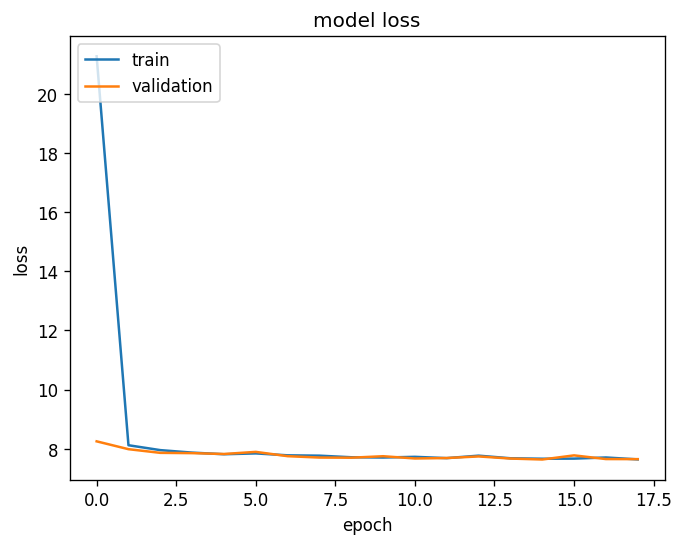

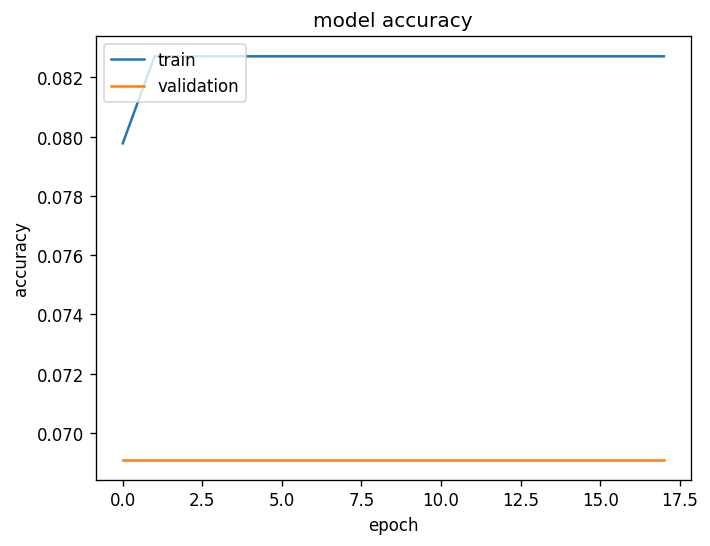

In [405]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [125]:
# "images" sizes
X_train = X_VGF_train.copy()
X_val = X_VGF_val.copy()
y_train = y_VGF_train.copy()
y_val = y_VGF_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# model.add(Dropout(0.2))
# hidden layer
model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  100 x 100
Shape before one-hot encoding:  (3541,)
Shape after one-hot encoding:  (3541, 20)
Epoch 1/100
111/111 [==============================] - 15s 135ms/step - loss: 40.9368 - accuracy: 0.2477 - val_loss: 24.0824 - val_accuracy: 0.4300
Epoch 2/100
111/111 [==============================] - 15s 134ms/step - loss: 24.3874 - accuracy: 0.4259 - val_loss: 24.6762 - val_accuracy: 0.4326
Epoch 3/100
111/111 [==============================] - 15s 135ms/step - loss: 24.4603 - accuracy: 0.5377 - val_loss: 24.0839 - val_accuracy: 0.6438
Epoch 4/100
111/111 [==============================] - 15s 134ms/step - loss: 24.2186 - accuracy: 0.6202 - val_loss: 24.1780 - val_accuracy: 0.6743


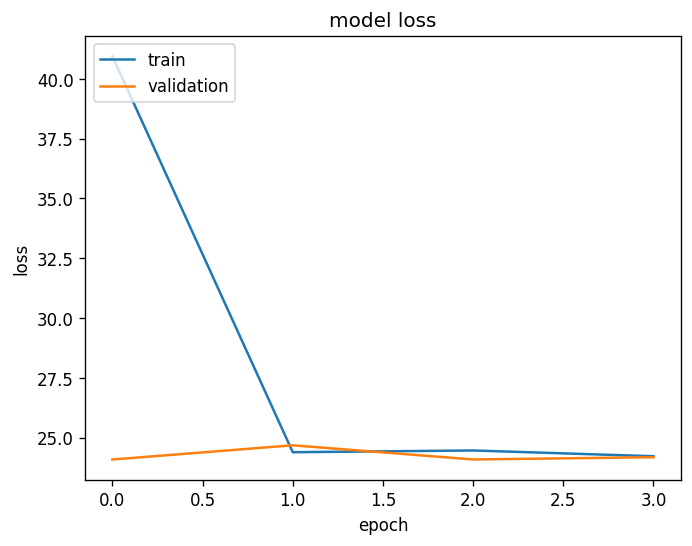

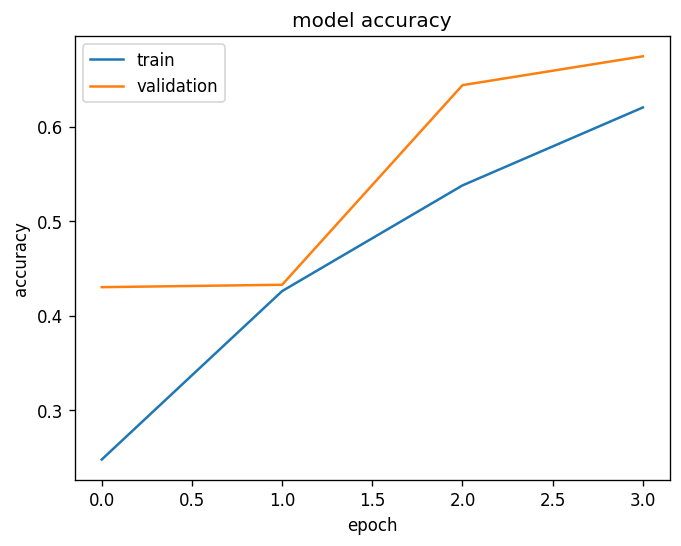

In [126]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Predicciones con el modelo Top 10

#### Para TextRank

In [406]:
len(X_VTR_test)

983

In [407]:
pred = model.predict(tf.convert_to_tensor(X_VTR_test))
predictions = np.argmax(pred, axis=-1)

In [408]:
print(predictions)

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15

#### Para Grados de Fractalidad

In [130]:
print(predictions[2])

12


In [131]:
pred = model.predict(tf.convert_to_tensor(X_VGF_test))
print(pred)
predictions = np.argmax(pred, axis=-1)

[[0.04468029 0.05144528 0.04247582 ... 0.04610961 0.05013559 0.03888661]
 [0.04468029 0.05144528 0.04247582 ... 0.04610961 0.05013559 0.03888661]
 [0.04468731 0.05141178 0.04245794 ... 0.04611985 0.05015032 0.03888654]
 ...
 [0.04468029 0.05144528 0.04247582 ... 0.04610961 0.05013559 0.03888661]
 [0.04468029 0.05144528 0.04247582 ... 0.04610961 0.05013559 0.03888661]
 [0.04468029 0.05144528 0.04247582 ... 0.04610961 0.05013559 0.03888661]]


In [132]:
print(predictions)

[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12

In [133]:
for i in range(len(predictions)):
    if predictions[i] != 12:
        print(i)

In [134]:
test_backup.iloc[934]

docs      sale decpc sxlp good condition year mhz intel ...
target                                                    3
TR        [disk, windows, microsoft, borland, year, mhz,...
GF               [microsoft, turbo, windows, borland, disk]
Name: 934, dtype: object

## Lee matrices de entrenamiento (Top 5)

In [135]:
X_VTR_train = np.load('X_VTR_train.npy', allow_pickle=True)
y_VTR_train = np.load('y_VTR_train.npy', allow_pickle=True)
X_VTR_val = np.load('X_VTR_val.npy', allow_pickle=True)
y_VTR_val = np.load('y_VTR_val.npy', allow_pickle=True)
X_VTR_test = np.load('X_VTR_test.npy', allow_pickle=True)

X_VGF_train = np.load('X_VGF_train.npy', allow_pickle=True)
y_VGF_train = np.load('y_VGF_train.npy', allow_pickle=True)
X_VGF_val = np.load('X_VGF_val.npy', allow_pickle=True)
y_VGF_val = np.load('y_VGF_val.npy', allow_pickle=True)
X_VGF_test = np.load('X_VGF_test.npy', allow_pickle=True)

In [136]:
print(X_VTR_train.shape, y_VTR_train.shape)
print(X_VGF_train.shape, y_VGF_train.shape)

print(X_VTR_val.shape, y_VTR_val.shape)
print(X_VGF_val.shape, y_VGF_val.shape)

print(X_VTR_test.shape)
print(X_VGF_test.shape)

(3541, 100, 100) (3541,)
(3541, 100, 100) (3541,)
(393, 100, 100) (393,)
(393, 100, 100) (393,)
(983, 100, 100)
(983, 100, 100)


In [137]:

X_VTR_train = X_VTR_train.reshape(X_VTR_train.shape[0], X_VTR_train.shape[1], X_VTR_train.shape[2], 1)[:,:5,:,:]
X_VTR_train = X_VTR_train.astype('float32')

X_VGF_train = X_VGF_train.reshape(X_VGF_train.shape[0], X_VGF_train.shape[1], X_VGF_train.shape[2], 1)[:,:5,:,:]
X_VGF_train = X_VGF_train.astype('float32')

X_VTR_val = X_VTR_val.reshape(X_VTR_val.shape[0], X_VTR_val.shape[1], X_VTR_val.shape[2], 1)[:,:5,:,:]
X_VTR_val = X_VTR_val.astype('float32')

X_VGF_val = X_VGF_val.reshape(X_VGF_val.shape[0], X_VGF_val.shape[1], X_VGF_val.shape[2], 1)[:,:5,:,:]
X_VGF_val = X_VGF_val.astype('float32')

X_VTR_test = X_VTR_test.reshape(X_VTR_test.shape[0], X_VTR_test.shape[1], X_VTR_test.shape[2], 1)[:,:5,:,:]

X_VGF_test = X_VGF_test.reshape(X_VGF_test.shape[0], X_VGF_test.shape[1], X_VGF_test.shape[2], 1)[:,:5,:,:]

print(X_VTR_train.shape)
print(y_VTR_train.shape)

print(X_VGF_train.shape)
print(y_VGF_train.shape)

print(X_VTR_test.shape)

print(X_VGF_test.shape)

(3541, 5, 100, 1)
(3541,)
(3541, 5, 100, 1)
(3541,)
(983, 5, 100, 1)
(983, 5, 100, 1)


# Clasificación usando CNN

In [138]:
# "images" sizes
X_train = X_VTR_train.copy()
X_val = X_VTR_val.copy()
y_train = y_VTR_train.copy()
y_val = y_VTR_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(100, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
model.add(BatchNormalization())
# model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  5 x 100
Shape before one-hot encoding:  (3541,)
Shape after one-hot encoding:  (3541, 20)
Epoch 1/100
111/111 [==============================] - 1s 7ms/step - loss: 20.1725 - accuracy: 0.5374 - val_loss: 6.9318 - val_accuracy: 0.4911
Epoch 2/100
111/111 [==============================] - 1s 7ms/step - loss: 4.8445 - accuracy: 0.5953 - val_loss: 5.0847 - val_accuracy: 0.6107
Epoch 3/100
111/111 [==============================] - 1s 7ms/step - loss: 3.8696 - accuracy: 0.6351 - val_loss: 4.1259 - val_accuracy: 0.6158
Epoch 4/100
111/111 [==============================] - 1s 7ms/step - loss: 3.5231 - accuracy: 0.6416 - val_loss: 3.5692 - val_accuracy: 0.6947
Epoch 5/100
111/111 [==============================] - 1s 7ms/step - loss: 3.3402 - accuracy: 0.6701 - val_loss: 3.3120 - val_accuracy: 0.6921
Epoch 6/100
111/111 [==============================] - 1s 7ms/step - loss: 3.2786 - accuracy: 0.6699 - val_loss: 3.2363 - val_accuracy: 0.7125
Epoch 7/100
111/111 [=========

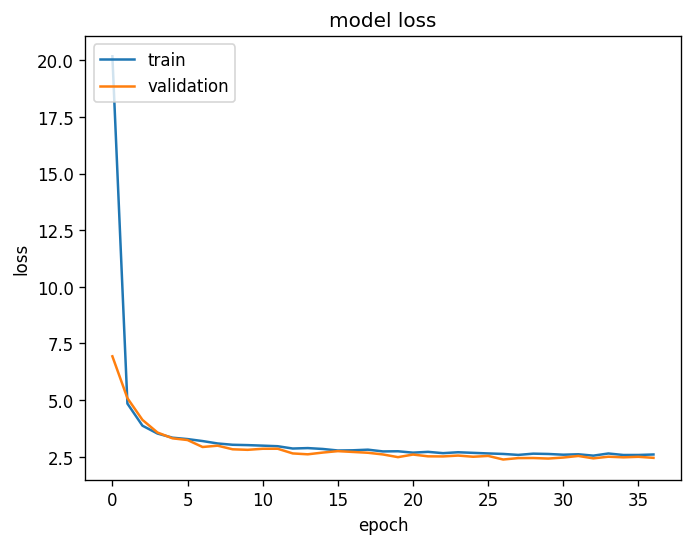

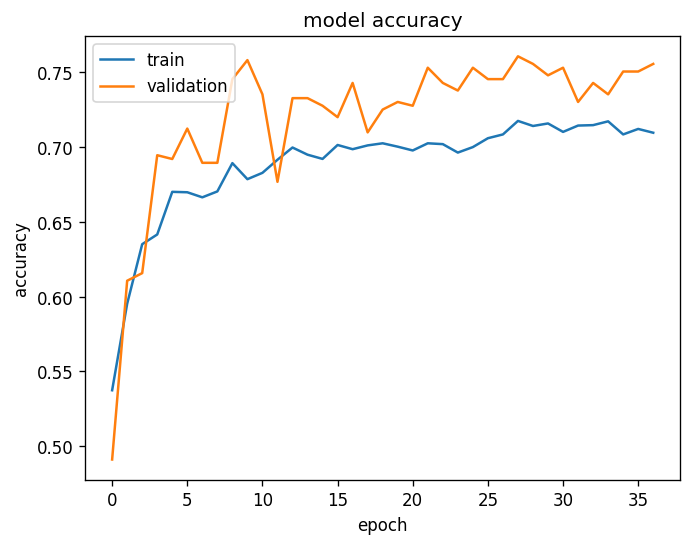

In [139]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [140]:
# "images" sizes
X_train = X_VGF_train.copy()
X_val = X_VGF_val.copy()
y_train = y_VGF_train.copy()
y_val = y_VGF_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(128, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
model.add(BatchNormalization())
model.add(Dense(64, activation='leaky_relu'))
model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  5 x 100
Shape before one-hot encoding:  (3541,)
Shape after one-hot encoding:  (3541, 20)
Epoch 1/100
111/111 [==============================] - 1s 9ms/step - loss: 24.6328 - accuracy: 0.5191 - val_loss: 8.0012 - val_accuracy: 0.3486
Epoch 2/100
111/111 [==============================] - 1s 8ms/step - loss: 6.3078 - accuracy: 0.5600 - val_loss: 6.4197 - val_accuracy: 0.3690
Epoch 3/100
111/111 [==============================] - 1s 8ms/step - loss: 4.9926 - accuracy: 0.6097 - val_loss: 5.0711 - val_accuracy: 0.5802
Epoch 4/100
111/111 [==============================] - 1s 8ms/step - loss: 4.1950 - accuracy: 0.6377 - val_loss: 4.4354 - val_accuracy: 0.6081
Epoch 5/100
111/111 [==============================] - 1s 8ms/step - loss: 3.8742 - accuracy: 0.6428 - val_loss: 3.7554 - val_accuracy: 0.6387
Epoch 6/100
111/111 [==============================] - 1s 8ms/step - loss: 3.6576 - accuracy: 0.6589 - val_loss: 3.5047 - val_accuracy: 0.6565
Epoch 7/100
111/111 [=========

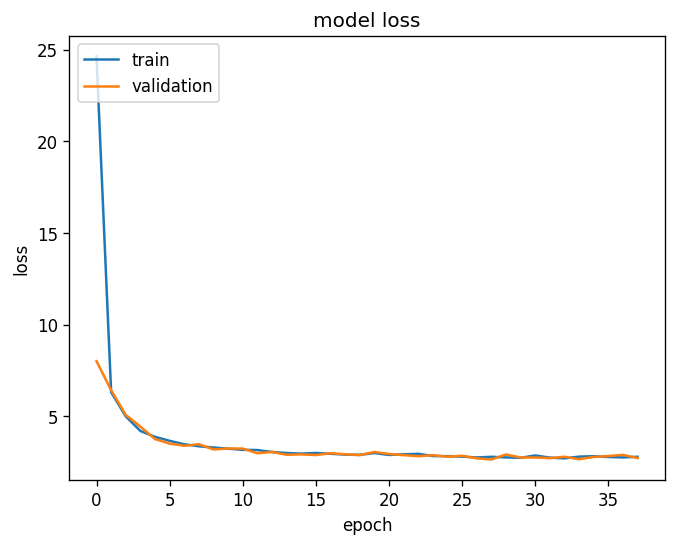

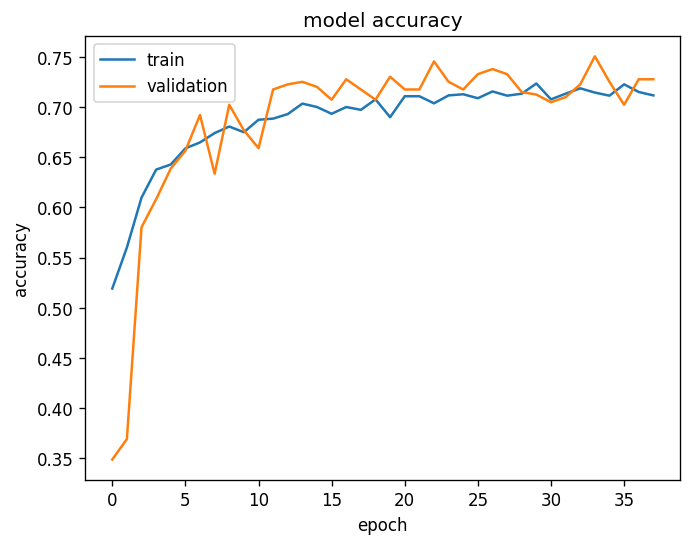

In [141]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### TEST del modelo con el dataframe de test

In [142]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 3, 98, 25)         250       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 98, 25)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 7350)              0         
                                                                 
 dropout_1 (Dropout)         (None, 7350)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               940928    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                      

In [143]:
test

,TR_values,GF_values
0,"[[0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -...","[[0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -..."
1,"[[1.7688590515172166e-41, 2.067910156788776e-4...","[[1.2095127677191897e-10, 1.4139626136611128e-..."
2,"[[2.891939743232541e-10, 8.05908229040142e-10,...","[[0.0009453801321797073, 0.002634527860209346,..."
3,"[[0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, ...","[[0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, ..."
4,"[[7.748969817259943e-22, 4.585859730554596e-22...","[[4.6396292551580855e-17, 2.7457441524891326e-..."
...,...,...
978,"[[1.6451045419175747e-22, 3.6050549569236353e-...","[[1.7580367162040034e-09, 3.852532959314203e-0..."
979,"[[0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0,...","[[2.8820612356556818e-28, 1.6225698577213755e-..."
980,"[[0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0...","[[8.866823941744428e-11, 5.116772561208904e-10..."
981,"[[0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, ...","[[0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0..."


In [144]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TR_values  983 non-null    object
 1   GF_values  983 non-null    object
dtypes: object(2)
memory usage: 15.5+ KB


In [145]:
placeholder = test.TR_values.values

In [429]:
#placeholder

In [147]:
pred = model.predict(tf.convert_to_tensor(X_VTR_test))
predictions = np.argmax(pred, axis=-1)

print(predictions)

[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12

In [148]:
pred = model.predict(tf.convert_to_tensor(X_VGF_test))
predictions = np.argmax(pred, axis=-1)

print(predictions)

[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 14 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12

In [149]:
with np.printoptions(threshold=np.inf):
    print(len(test.iloc[0].TR_values))


100


In [150]:
test

,TR_values,GF_values
0,"[[0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -...","[[0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -..."
1,"[[1.7688590515172166e-41, 2.067910156788776e-4...","[[1.2095127677191897e-10, 1.4139626136611128e-..."
2,"[[2.891939743232541e-10, 8.05908229040142e-10,...","[[0.0009453801321797073, 0.002634527860209346,..."
3,"[[0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, ...","[[0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, ..."
4,"[[7.748969817259943e-22, 4.585859730554596e-22...","[[4.6396292551580855e-17, 2.7457441524891326e-..."
...,...,...
978,"[[1.6451045419175747e-22, 3.6050549569236353e-...","[[1.7580367162040034e-09, 3.852532959314203e-0..."
979,"[[0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0,...","[[2.8820612356556818e-28, 1.6225698577213755e-..."
980,"[[0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0...","[[8.866823941744428e-11, 5.116772561208904e-10..."
981,"[[0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, ...","[[0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0..."
